In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import unicodedata, re, string
import nltk
from textblob import TextBlob
from collections import Counter
import itertools

from transformers import pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Flatten, Dense, Dropout

from keras.callbacks import ReduceLROnPlateau

from sklearn.feature_extraction.text import CountVectorizer
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import string

import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/kaggle/input/rotten-tomatoes-reviews/rt_reviews.csv
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Some functions that will help us later 

In [96]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def fix_nt(words):
    st_res = []
    for i in range(len(words)-1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    if (len(words)>2 and words[len(words)-1] != "nt" and words[len(words)-1] !="n't"):
        st_res.append(words[len(words)-1])            
    return st_res


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words) # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    words = remove_numbers(words)     # 0123456789
    words = remove_stopwords(words)   # nenesou významnou informaci (he, she, a, the, ...)
    return words

def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return tweet_blob.words


def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

def encodeLabel(label):
    if label == 5 or label == 4: #If the rating is generally positive
        return 2 
    if label == 3: #If the rating is neutral
        return 1 
    return 0 #Give the rating a 0 for negative (1 or 2 rating)

def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()
    
def encodeLabel(label):
    if label == 5 or label == 4: #If the rating is generally positive
        return 2 
    if label == 3: #If the rating is neutral
        return 1 
    return 0 #Give the rating a 0 for negative (1 or 2 rating)

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

# Rotten tomato movie reviews

This dataset is a collection of movie reviews sourced from the popular movie review website Rotten Tomatoes.

The dataset includes both the text of the reviews and a label indicating whether the review was classified as "fresh" or "rotten" based on Rotten Tomatoes' unique review aggregation system. 

**fresh** = positive/good review

**rotten** = negative/bad review

## Date preview and preparation

In [97]:
df = pd.read_csv('/kaggle/input/rotten-tomatoes-reviews/rt_reviews.csv',encoding='latin1')
df.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [98]:
df.isnull().sum()

Freshness    0
Review       0
dtype: int64

We got no null values

### Let's take a look at class distribution

Text(0.5, 1.0, 'Distribution of scores')

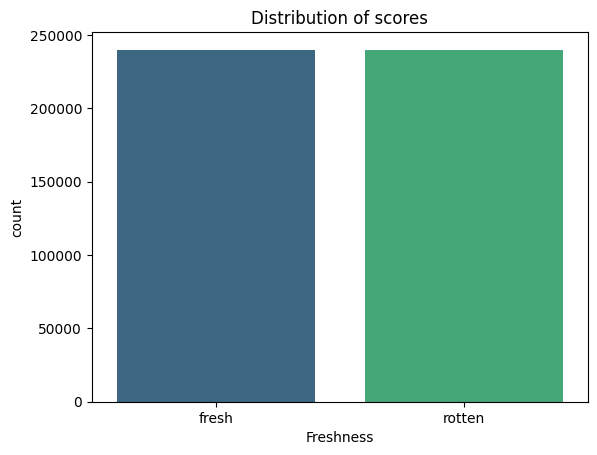

In [99]:
sns.countplot(data=df, x="Freshness", palette="viridis").set_title("Distribution of scores")

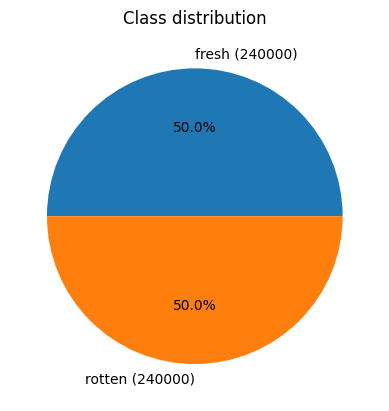

In [100]:
rating_counts = df["Freshness"].value_counts()

plt.pie(rating_counts, labels=[f"{label} ({count})" for label, count in zip(rating_counts.index, rating_counts)], autopct='%1.1f%%')
plt.title("Class distribution")
plt.show()

We got nicely distributed classes 50/50

In [101]:
df.shape

(480000, 2)

There is 480 000 reviews which is a lot so we could reduce it and use only 100 000. This should be enough

### Okay let's reduce our dataset

In [102]:
df = df[:100000]

Let's change labels from 'rotten' to 0 and 'fresh' to 1 

In [103]:
df['Freshness'] = df['Freshness'].apply(lambda x: 1 if x=='fresh' else 0)
df.head()

,Freshness,Review
0,1,"Manakamana doesn't answer any questions, yet ..."
1,1,Wilfully offensive and powered by a chest-thu...
2,0,It would be difficult to imagine material mor...
3,0,Despite the gusto its star brings to the role...
4,0,If there was a good idea at the core of this ...


Now we have our dataset ready for preprocessing

## Let's take at length in words and characters to have better understanding what should we expect

### First let's look at characters

In [104]:
df["length"] = df["Review"].apply(len)
df.head()

,Freshness,Review,length
0,1,"Manakamana doesn't answer any questions, yet ...",147
1,1,Wilfully offensive and powered by a chest-thu...,86
2,0,It would be difficult to imagine material mor...,82
3,0,Despite the gusto its star brings to the role...,106
4,0,If there was a good idea at the core of this ...,167


In [105]:
df["length"].describe()

count    100000.000000
mean        131.624350
std          54.877188
min          18.000000
25%          90.000000
50%         130.000000
75%         170.000000
max         287.000000
Name: length, dtype: float64

Shortest review has 18 characters and longest 260. 

Let's take a look at graph to better visualize character lenght in Reviews

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



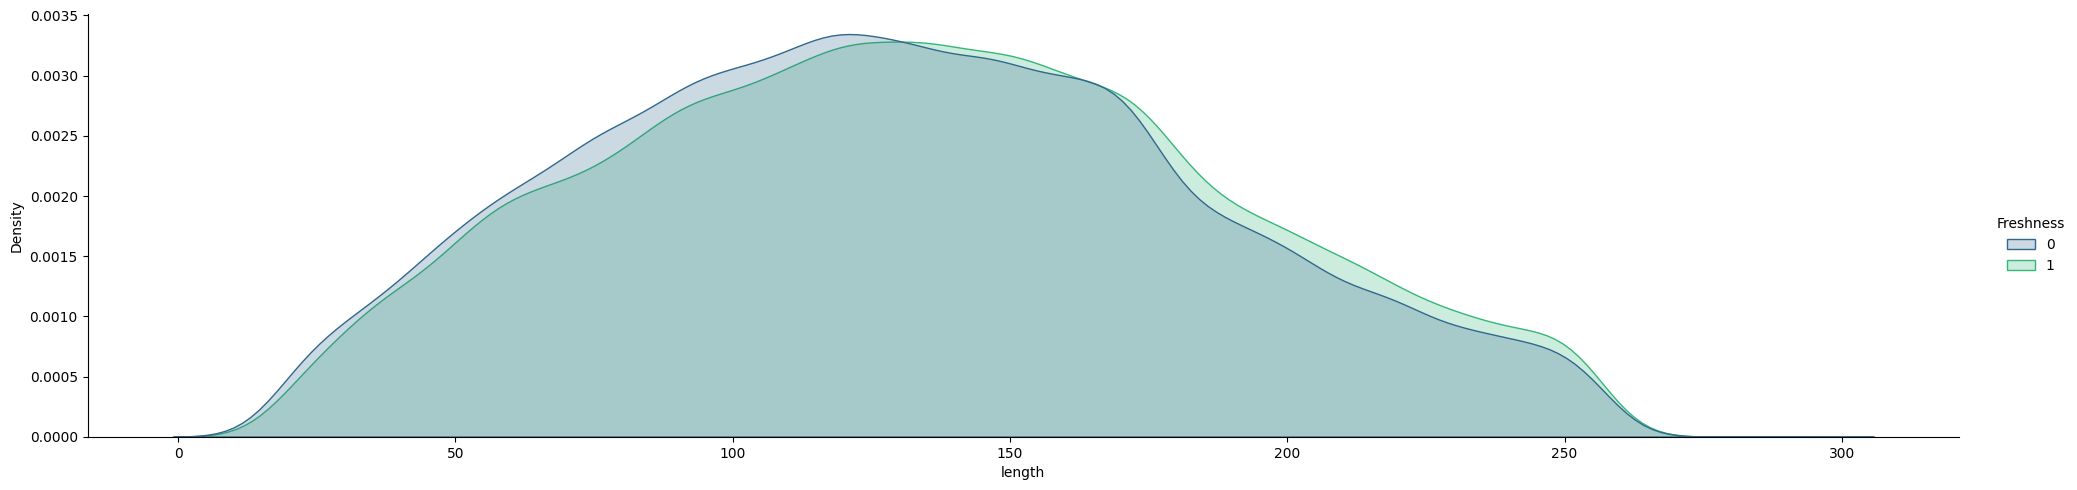

In [106]:
sns.displot(data=df, x="length", hue="Freshness", palette="viridis", kind="kde", fill=True, aspect=4)

Pretty similar distribution in classes.

### Now let's take a look at words length in Reviews

In [107]:
df["length_words"] = df["Review"].str.split().apply(len)
df.head()

,Freshness,Review,length,length_words
0,1,"Manakamana doesn't answer any questions, yet ...",147,24
1,1,Wilfully offensive and powered by a chest-thu...,86,13
2,0,It would be difficult to imagine material mor...,82,15
3,0,Despite the gusto its star brings to the role...,106,19
4,0,If there was a good idea at the core of this ...,167,31


In [108]:
df["length_words"].describe()

count    100000.000000
mean         21.754610
std           9.362974
min           1.000000
25%          15.000000
50%          21.000000
75%          28.000000
max          53.000000
Name: length_words, dtype: float64

Shortest review has 1 word and longest 53 words. Pretty short reviews i have to say, maybe they have some cap on how long a Review can be.

Once again visualize in graph.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



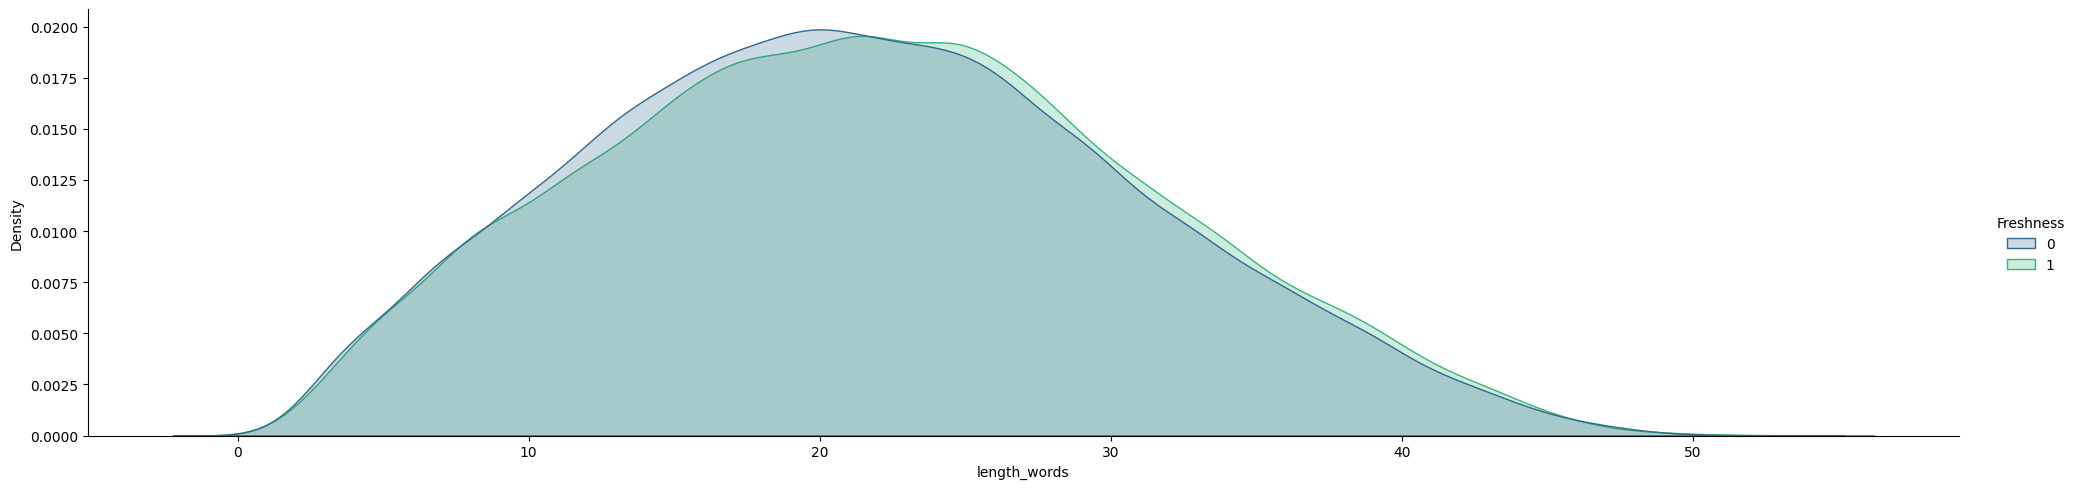

In [109]:
sns.displot(data=df, x="length_words", hue="Freshness", palette="viridis", kind="kde", fill=True, aspect=4)

Again pretty similar distribution. There is no corelation between length of Review and its 'Freshness'.

Lets take a look at the shortest and longest reviews:

In [110]:
most_words_message = df.loc[df['length_words'].idxmax(), 'Review']
least_words_message = df.loc[df['length_words'].idxmin(), 'Review']

print("Review with the most words:")
print(most_words_message)
print()

print("Review with the least words:")
print(least_words_message)

Review with the most words:
 It's weird and surreal, but it ends with most of the holes plugged and all but a few of the loose ends tied into a tidy package. Some argue this is a cheat and the film should have been more open ended. That's a personal choice; I like it the way it is.

Review with the least words:
 'Dough'-lightful! 


I expected shortest Review to have only 1 word but it turned out to be 3 connected with dots

### Are there any odd characters?

In [111]:
chars = set()

for item in df["Review"]:
    chars = chars.union(item)
    
chars = sorted(chars)

print(chars)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}', '½', '¿', 'ï', 'ý']


Indeed, there are some odd characters. We should probably do something about them later

## Review normalization

In [112]:
df['words'] = df['Review'].apply(form_sentence)
df.head()

,Freshness,Review,length,length_words,words
0,1,"Manakamana doesn't answer any questions, yet ...",147,24,"[Manakamana, does, n't, answer, any, questions..."
1,1,Wilfully offensive and powered by a chest-thu...,86,13,"[Wilfully, offensive, and, powered, by, a, che..."
2,0,It would be difficult to imagine material mor...,82,15,"[It, would, be, difficult, to, imagine, materi..."
3,0,Despite the gusto its star brings to the role...,106,19,"[Despite, the, gusto, its, star, brings, to, t..."
4,0,If there was a good idea at the core of this ...,167,31,"[If, there, was, a, good, idea, at, the, core,..."


Let's make sure everything is normalized (remove non ascii, stopwords, numbers, punctuation and make everything lowercase)

In [113]:
df['words_normalized'] = df['words'].apply(normalize)
df.head()

,Freshness,Review,length,length_words,words,words_normalized
0,1,"Manakamana doesn't answer any questions, yet ...",147,24,"[Manakamana, does, n't, answer, any, questions...","[manakamana, nt, answer, questions, yet, makes..."
1,1,Wilfully offensive and powered by a chest-thu...,86,13,"[Wilfully, offensive, and, powered, by, a, che...","[wilfully, offensive, powered, chestthumping, ..."
2,0,It would be difficult to imagine material mor...,82,15,"[It, would, be, difficult, to, imagine, materi...","[would, difficult, imagine, material, wrong, s..."
3,0,Despite the gusto its star brings to the role...,106,19,"[Despite, the, gusto, its, star, brings, to, t...","[despite, gusto, star, brings, role, hard, rid..."
4,0,If there was a good idea at the core of this ...,167,31,"[If, there, was, a, good, idea, at, the, core,...","[good, idea, core, film, buried, unsightly, pi..."


also let's fix nt to be properly in Reviews

In [114]:
df['words_normalized_fixed'] = df['words_normalized'].apply(fix_nt)
df.head()

,Freshness,Review,length,length_words,words,words_normalized,words_normalized_fixed
0,1,"Manakamana doesn't answer any questions, yet ...",147,24,"[Manakamana, does, n't, answer, any, questions...","[manakamana, nt, answer, questions, yet, makes...","[manakamanan't, answer, questions, yet, makes,..."
1,1,Wilfully offensive and powered by a chest-thu...,86,13,"[Wilfully, offensive, and, powered, by, a, che...","[wilfully, offensive, powered, chestthumping, ...","[wilfully, offensive, powered, chestthumping, ..."
2,0,It would be difficult to imagine material mor...,82,15,"[It, would, be, difficult, to, imagine, materi...","[would, difficult, imagine, material, wrong, s...","[would, difficult, imagine, material, wrong, s..."
3,0,Despite the gusto its star brings to the role...,106,19,"[Despite, the, gusto, its, star, brings, to, t...","[despite, gusto, star, brings, role, hard, rid...","[despite, gusto, star, brings, role, hard, rid..."
4,0,If there was a good idea at the core of this ...,167,31,"[If, there, was, a, good, idea, at, the, core,...","[good, idea, core, film, buried, unsightly, pi...","[good, idea, core, film, buried, unsightly, pi..."


Now let's create sentences back from splitted words

In [115]:
df['clean_Review'] = df['words_normalized_fixed'].apply(lambda x: " ".join(x))
df.head()

,Freshness,Review,length,length_words,words,words_normalized,words_normalized_fixed,clean_Review
0,1,"Manakamana doesn't answer any questions, yet ...",147,24,"[Manakamana, does, n't, answer, any, questions...","[manakamana, nt, answer, questions, yet, makes...","[manakamanan't, answer, questions, yet, makes,...",manakamanan't answer questions yet makes point...
1,1,Wilfully offensive and powered by a chest-thu...,86,13,"[Wilfully, offensive, and, powered, by, a, che...","[wilfully, offensive, powered, chestthumping, ...","[wilfully, offensive, powered, chestthumping, ...",wilfully offensive powered chestthumping machi...
2,0,It would be difficult to imagine material mor...,82,15,"[It, would, be, difficult, to, imagine, materi...","[would, difficult, imagine, material, wrong, s...","[would, difficult, imagine, material, wrong, s...",would difficult imagine material wrong spade l...
3,0,Despite the gusto its star brings to the role...,106,19,"[Despite, the, gusto, its, star, brings, to, t...","[despite, gusto, star, brings, role, hard, rid...","[despite, gusto, star, brings, role, hard, rid...",despite gusto star brings role hard ride shotg...
4,0,If there was a good idea at the core of this ...,167,31,"[If, there, was, a, good, idea, at, the, core,...","[good, idea, core, film, buried, unsightly, pi...","[good, idea, core, film, buried, unsightly, pi...",good idea core film buried unsightly pile flat...


In [116]:
chars = set()

for item in df["clean_Review"]:
    chars = chars.union(item)
    
chars = sorted(chars)

print(chars)

[' ', "'", '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## What are the most common words?

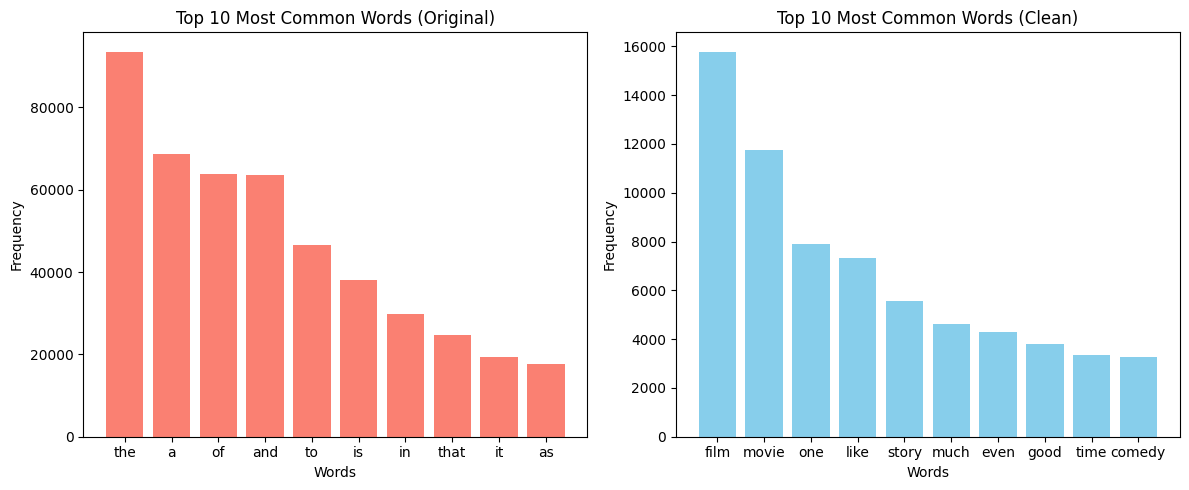

In [117]:
# Get all the original reviews
original_reviews = df["Review"]
original_words = [word for review in original_reviews for word in review.split()]

# Count the frequency of each word in original reviews
original_word_counts = Counter(original_words)
top_10_original_words = original_word_counts.most_common(10)
original_words, original_counts = zip(*top_10_original_words)

# Get all the clean reviews
clean_reviews = df["clean_Review"]
clean_words = [word for review in clean_reviews for word in review.split()]

# Count the frequency of each word in clean reviews
clean_word_counts = Counter(clean_words)
top_10_clean_words = clean_word_counts.most_common(10)
clean_words, clean_counts = zip(*top_10_clean_words)


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for original reviews
axs[0].bar(original_words, original_counts, color='salmon')
axs[0].set_title("Top 10 Most Common Words (Original)")
axs[0].set_xlabel("Words")
axs[0].set_ylabel("Frequency")

# Plot for clean reviews
axs[1].bar(clean_words, clean_counts, color='skyblue')
axs[1].set_title("Top 10 Most Common Words (Clean)")
axs[1].set_xlabel("Words")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


As we can see in original reviews there was a lot of words, that don't give much advice if the text is positive or negative.

in the clean reviews, there is a lot of words 'film' and 'movie' which makes sense. Then there is a lot of 'like' and 'good' which could give hints that the review is positive.

## What are the most common words in positive and negative reviews?

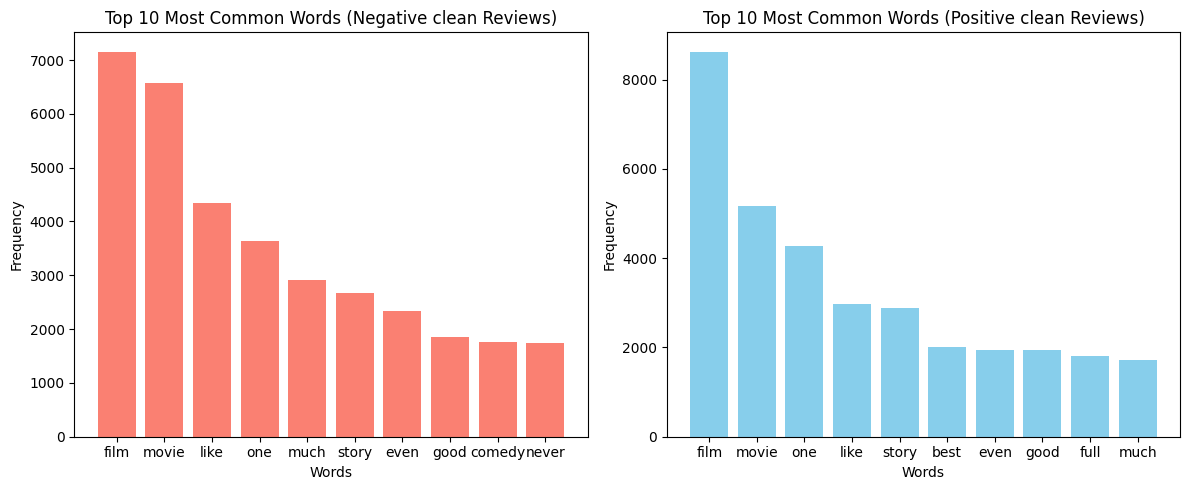

In [118]:
# Get all the original reviews
negative_df = df[df['Freshness']==0]
negative_reviews = negative_df['clean_Review']
negative_words = [word for review in negative_reviews for word in review.split()]

# Count the frequency of each word in original reviews
negative_word_counts = Counter(negative_words)
top_10_negative_words = negative_word_counts.most_common(10)
negative_words, negative_counts = zip(*top_10_negative_words)

# Get all the clean reviews
positive_df = df[df['Freshness']==1]
positive_reviews = positive_df["clean_Review"]
positive_words = [word for review in positive_reviews for word in review.split()]

# Count the frequency of each word in clean reviews
positive_word_counts = Counter(positive_words)
top_10_positive_words = positive_word_counts.most_common(10)
positive_words, positive_counts = zip(*top_10_positive_words)


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for negative reviews
axs[0].bar(negative_words, negative_counts, color='salmon')
axs[0].set_title("Top 10 Most Common Words (Negative clean Reviews)")
axs[0].set_xlabel("Words")
axs[0].set_ylabel("Frequency")

# Plot for positive reviews
axs[1].bar(positive_words, positive_counts, color='skyblue')
axs[1].set_title("Top 10 Most Common Words (Positive clean Reviews)")
axs[1].set_xlabel("Words")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In both graphs, we can see that the words 'film' and 'movie' are in the highest concentration. 

What i expected were more negative words in negative Reviews. We only got 'never' at 10th place.

On the other hand positive Reviews are just like i imagined. All 10 top words are positive or neutral ('film'...).

## Words

In [119]:
all_words = list(itertools.chain(*df.words_normalized_fixed))
all_words[:10]

["manakamanan't",
 'answer',
 'questions',
 'yet',
 'makes',
 'point',
 'nepal',
 'like',
 'rest',
 'planet']

In [120]:
dist = nltk.FreqDist(all_words)
dist

FreqDist({'film': 15784, 'movie': 11749, 'one': 7913, 'like': 7322, 'story': 5566, 'much': 4631, 'even': 4289, 'good': 3794, 'time': 3337, 'comedy': 3268, ...})

Frequency of words in our reviews

In [121]:
print(len(all_words))
print(len(dist))

1212740
67220


We have completely **1 212 740** words 

and **67 220** unique words

## What are some common n-grams

### Let's take a look at Bigrams

In [122]:
# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top 10 most common 2-grams
top_n_2grams = _get_top_ngram(df["clean_Review"], 2)[:10]
ngram_values, ngram_counts = zip(*top_n_2grams)

# Create a subplot
fig = make_subplots(rows=1, cols=1)

# Add a bar trace for 2-grams
fig.add_trace(go.Bar(
    x=ngram_counts,
    y=ngram_values,
    orientation='h',
    marker=dict(color="skyblue"),
    name="2-grams"
), row=1, col=1)

# Update layout
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,
    title=dict(
        text='<b>Most Common bigrams</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",
            size=24,
            color="RebeccaPurple"
        )
    )
)

fig.show()

The most common bigram is 'full review' which isn't a big hint to determine score. It looks like they are describing film parameters not actually their feelings about the film. But 'one best' could be a hint, because it could have been 'one of the best...' but we removed stopwords ('the', 'of', ...)

### What about trigrams?

In [123]:
# Count the frequency of each word
word_counts = Counter(all_words)

# Get the top 10 most common 3-grams
top_n_3grams = _get_top_ngram(df["clean_Review"], 3)[:10]
ngram_values, ngram_counts = zip(*top_n_3grams)

# Create a subplot
fig = make_subplots(rows=1, cols=1)

# Add a bar trace for 3-grams
fig.add_trace(go.Bar(
    x=ngram_counts,
    y=ngram_values,
    orientation='h',
    marker=dict(color="skyblue"),
    name="3-grams"
), row=1, col=1)

# Update layout
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,
    title=dict(
        text='<b>Most Common trigrams</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",
            size=24,
            color="RebeccaPurple"
        )
    )
)

fig.show()

Those are 10 most common trigrams. Number one trigram is 'full review spanish'.

# Model 1

## Tokenizing and padding 

give each word unique number (token)

In [124]:
NUMBER_OF_TOKENS=5000  # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

In [125]:
review = df["clean_Review"].copy()

print("Example Sentence: ") 
print(review[29632])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[29632])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[29632])

Example Sentence: 
movie fits perfectly terry gilliam oeuvre except fact dismal rank bore misses thematic mark becomes complete nightmare
Into a Sequence: 
[2, 1753, 487, 4117, 2816, 683, 315, 4701, 1372, 1650, 2237, 595, 203, 626, 1506]
After Padding: 
[   2 1753  487 4117 2816  683  315 4701 1372 1650 2237  595  203  626
 1506    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Split the data for training and testing

In [126]:
X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

In [127]:
print(df.shape[0])
print('\nTraining and testing shape:')
print(X_train.shape, X_test.shape)

print('\nTrain')
print(y_train.value_counts())
print('\nTest')
print(y_test.value_counts())

100000

Training and testing shape:
(80000, 100) (20000, 100)

Train
Freshness
0    40029
1    39971
Name: count, dtype: int64

Test
Freshness
0    10007
1     9993
Name: count, dtype: int64


## Our first model

In [128]:
model_simple_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_simple_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_simple_1.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_15         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [129]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

## Training

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0.5243 - loss: 0.6926 - val_binary_accuracy: 0.5671 - val_loss: 0.6900
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6034 - loss: 0.6876 - val_binary_accuracy: 0.6418 - val_loss: 0.6767
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6663 - loss: 0.6659 - val_binary_accuracy: 0.5746 - val_loss: 0.6677
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6656 - loss: 0.6352 - val_binary_accuracy: 0.7031 - val_loss: 0.5955
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - binary_accuracy: 0.7272 - loss: 0.5709 - val_binary_accuracy: 0.7238 - val_loss: 0.5618


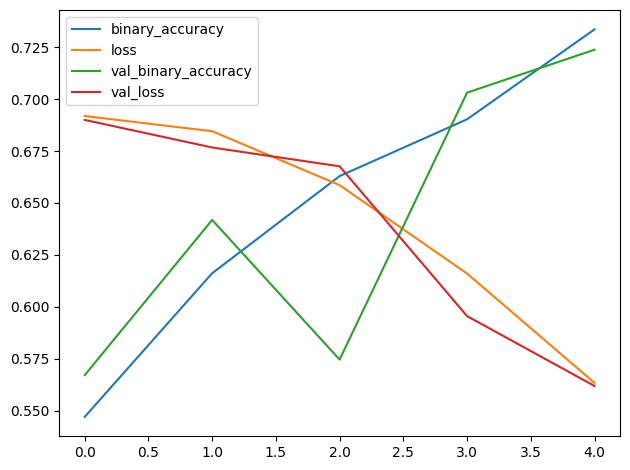

In [130]:
epochs = 5
batch_size=512

history = model_simple_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

In [131]:
model_simple_1.load_weights("load.weights.h5")

In [132]:
y_pred = model_simple_1.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') #We can use accuracy because classes are balanced
accuracy_simple_1 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.7274


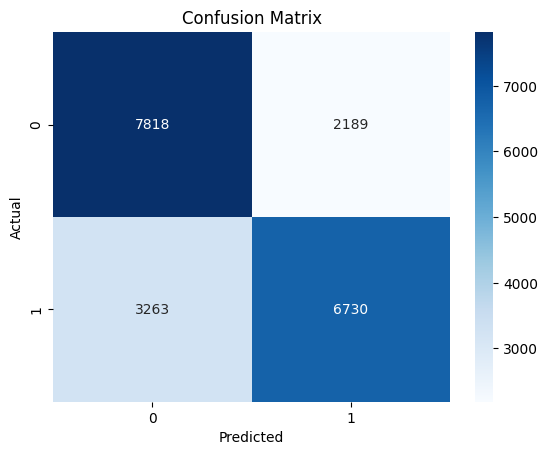

In [133]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Not so bad considering it's only basic model, let's try to increase

## let's try different optimizer

In [134]:
model_simple_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])

model_simple_2.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0.5164 - loss: 0.6926 - val_binary_accuracy: 0.6002 - val_loss: 0.6865
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6302 - loss: 0.6673 - val_binary_accuracy: 0.7172 - val_loss: 0.5685
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7448 - loss: 0.5276 - val_binary_accuracy: 0.7513 - val_loss: 0.5064
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7777 - loss: 0.4709 - val_binary_accuracy: 0.7546 - val_loss: 0.4998
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7894 - loss: 0.4514 - val_binary_accuracy: 0.7626 - val_loss: 0.4939


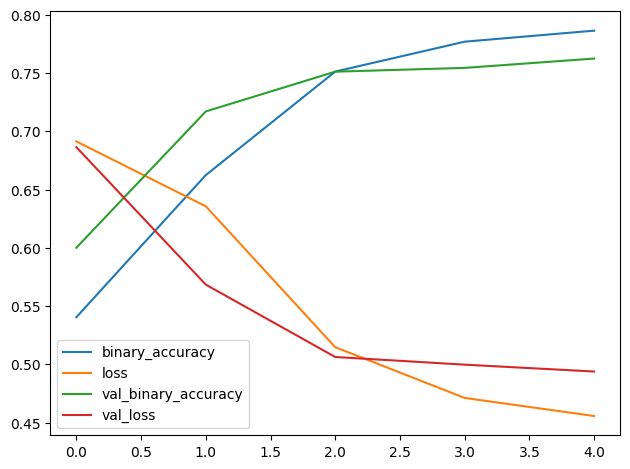

In [135]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 5
batch_size=512

history = model_simple_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

In [136]:
model_simple_2.load_weights("load.weights.h5")

y_pred = model_simple_2.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') #We can use accuracy because classes are balanced
accuracy_simple_2 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.7571


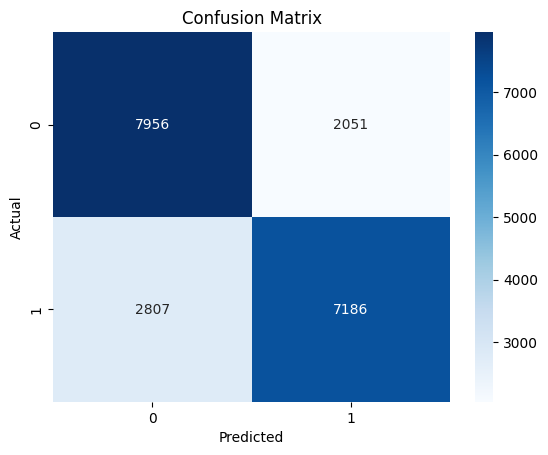

In [137]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Let's try to improve it

Increase number of unique words (tokens) and add some more layers to our model

In [138]:
NUMBER_OF_TOKENS=10000 # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

In [139]:
review = df["clean_Review"].copy()

print("Example Sentence: ") 
print(review[29632])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[29632])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[29632])

X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

Example Sentence: 
movie fits perfectly terry gilliam oeuvre except fact dismal rank bore misses thematic mark becomes complete nightmare
Into a Sequence: 
[2, 1753, 487, 4117, 2816, 5107, 683, 315, 4701, 5488, 1372, 1650, 2237, 595, 203, 626, 1506]
After Padding: 
[   2 1753  487 4117 2816 5107  683  315 4701 5488 1372 1650 2237  595
  203  626 1506    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [140]:
print(df.shape[0])
print('\nTraining and testing shape:')
print(X_train.shape, X_test.shape)

print('\nTrain')
print(y_train.value_counts())
print('\nTest')
print(y_test.value_counts())

100000

Training and testing shape:
(80000, 100) (20000, 100)

Train
Freshness
0    40029
1    39971
Name: count, dtype: int64

Test
Freshness
0    10007
1     9993
Name: count, dtype: int64


In [141]:
model_improved_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_improved_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_1.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_17         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - binary_accuracy: 0.5154 - loss: 0.6927 - val_binary_accuracy: 0.6327 - val_loss: 0.6896
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.6478 - loss: 0.6744 - val_binary_accuracy: 0.7103 - val_loss: 0.6300
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7359 - loss: 0.5543 - val_binary_accuracy: 0.7574 - val_loss: 0.5277
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.7922 - loss: 0.4692 - val_binary_accuracy: 0.7646 - val_loss: 0.5089
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.8090 - loss: 0.4433 - val_binary_accuracy: 0.7688 - val_loss: 0.4969
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.8227 - loss: 0.4218 - val_binary_accuracy: 0.7722 - val_loss: 0.4914
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.8346 - loss: 0.4020 - val_binary_accuracy: 0.7720 - val_loss: 0.4925
Epoch

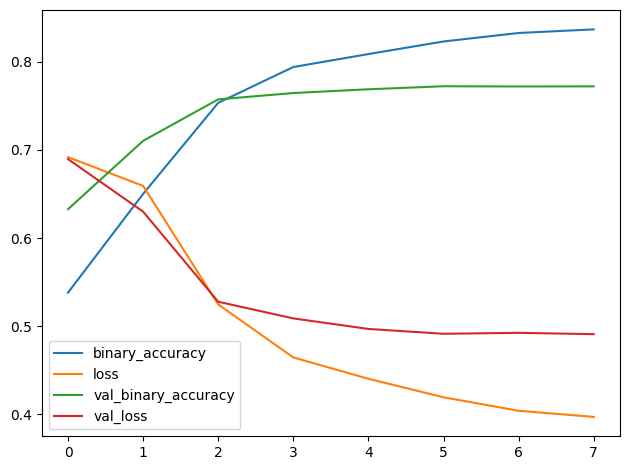

In [142]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

In [143]:
model_improved_1.load_weights("load.weights.h5")

In [144]:
y_pred = model_improved_1.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_1 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Accuracy: 0.76665


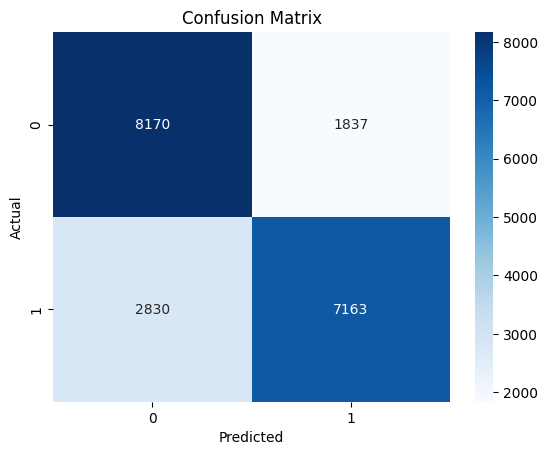

In [145]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Well we improved the results but not by a lot.

## Again let's try different optimizer

In [146]:
model_improved_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_improved_2.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_2.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_28                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_18         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - binary_accuracy: 0.5052 - loss: 0.6931 - val_binary_accuracy: 0.5424 - val_loss: 0.6909
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.5772 - loss: 0.6794 - val_binary_accuracy: 0.7037 - val_loss: 0.5875
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7406 - loss: 0.5331 - val_binary_accuracy: 0.7640 - val_loss: 0.5156
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7884 - loss: 0.4658 - val_binary_accuracy: 0.7690 - val_loss: 0.4955
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.8067 - loss: 0.4348 - val_binary_accuracy: 0.7653 - val_loss: 0.4934
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.8256 - loss: 0.4051 - val_binary_accuracy: 0.7718 - val_loss: 0.4836
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.8326 - loss: 0.3919 - val_binary_accuracy: 0.7736 - val_loss: 0.4891
Epoch 

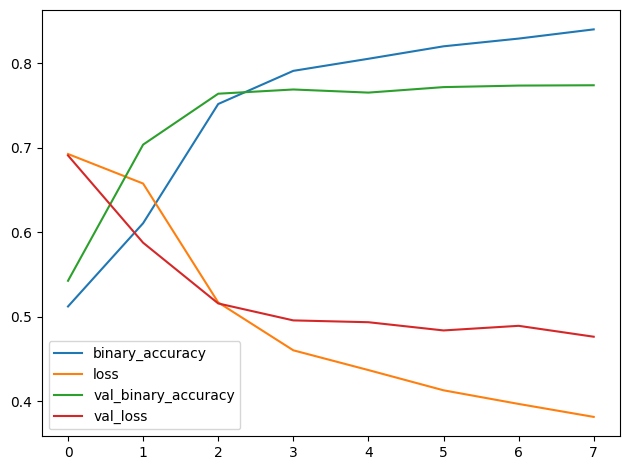

In [147]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

In [148]:
model_improved_2.load_weights("load.weights.h5")

y_pred = model_improved_2.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_2 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Accuracy: 0.76835


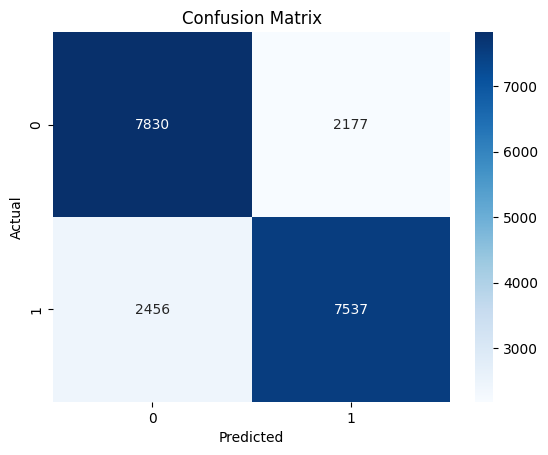

In [149]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Results of our models

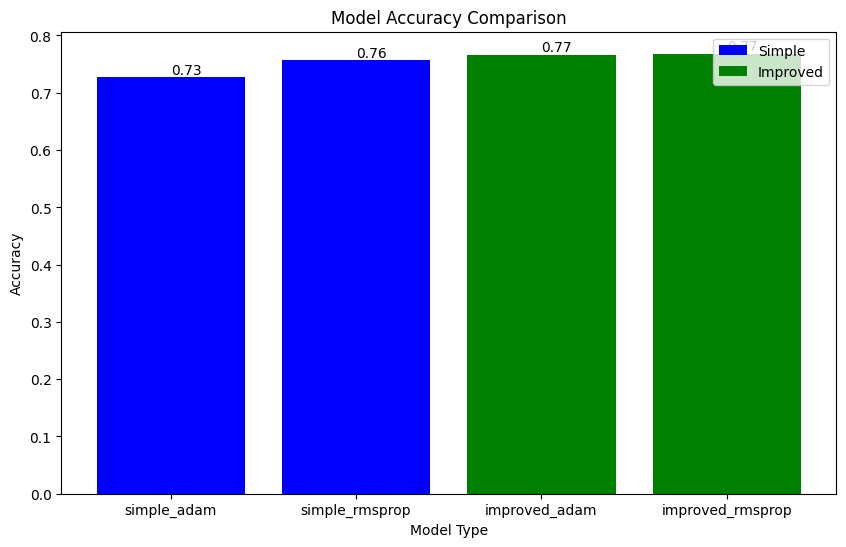

In [150]:
results = {
    'simple_adam': accuracy_simple_1,
    'simple_rmsprop': accuracy_simple_2,
    'improved_adam': accuracy_improved_1,
    'improved_rmsprop': accuracy_improved_2
}

labels = list(results.keys())
accuracies = list(results.values())

# Create a color map for the two groups (simple and improved)
colors = ['blue', 'blue', 'green', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=colors)

plt.title('Model Accuracy Comparison')
plt.xlabel('Model Type')
plt.ylabel('Accuracy')

# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Simple'),
                   Patch(facecolor='green', label='Improved')]
plt.legend(handles=legend_elements)

plt.show()

As we can see there is not much of an improvement in more complicated model.

Let's try different number of tokens on our 2 models which use rmsdrop optimizer

# Difference in number of tokens on our best models

We will try to show difference the number of tokens does to accuracy on our 2 models.

We will try 500, 1000, 2000, 5000, and finally tokenize all words

## Number of tokens: 500

In [151]:
NUMBER_OF_TOKENS=500 # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

review = df["clean_Review"].copy()

print("Example Sentence: ") 
print(review[29632])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[29632])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[29632])

X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

Example Sentence: 
movie fits perfectly terry gilliam oeuvre except fact dismal rank bore misses thematic mark becomes complete nightmare
Into a Sequence: 
[2, 487, 315, 203]
After Padding: 
[  2 487 315 203   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0.5211 - loss: 0.6923 - val_binary_accuracy: 0.5966 - val_loss: 0.6814
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6237 - loss: 0.6639 - val_binary_accuracy: 0.6261 - val_loss: 0.6417
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6569 - loss: 0.6208 - val_binary_accuracy: 0.6764 - val_loss: 0.6045
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6787 - loss: 0.5950 - val_binary_accuracy: 0.6749 - val_loss: 0.5980
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6816 - loss: 0.5888 - val_binary_accuracy: 0.6788 - val_loss: 0.5956


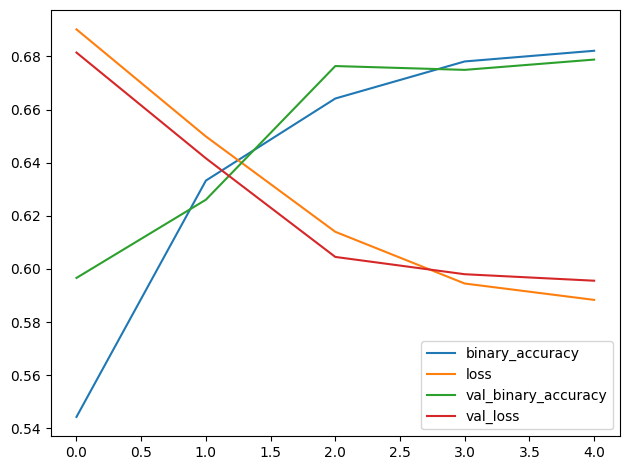

In [152]:
model_simple_500 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])

model_simple_500.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 5
batch_size=512

history = model_simple_500.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

In [153]:
model_simple_500.load_weights("load.weights.h5")

y_pred = model_simple_500.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') #We can use accuracy because classes are balanced
accuracy_simple_500 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.6783


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_21         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - binary_accuracy: 0.5048 - loss: 0.6934 - val_binary_accuracy: 0.5013 - val_loss: 0.6931
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.5215 - loss: 0.6916 - val_binary_accuracy: 0.6452 - val_loss: 0.6596
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.6384 - loss: 0.6450 - val_binary_accuracy: 0.6667 - val_loss: 0.6196
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.6707 - loss: 0.6098 - val_binary_accuracy: 0.6794 - val_loss: 0.6111
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.6758 - loss: 0.5991 - val_binary_accuracy: 0.6817 - val_loss: 0.6089
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.6783 - loss: 0.5939 - val_binary_accuracy: 0.6787 - val_loss: 0.6072
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.6809 - loss: 0.5930 - val_binary_accuracy: 0.6784 - val_loss: 0.6046
Epoch 

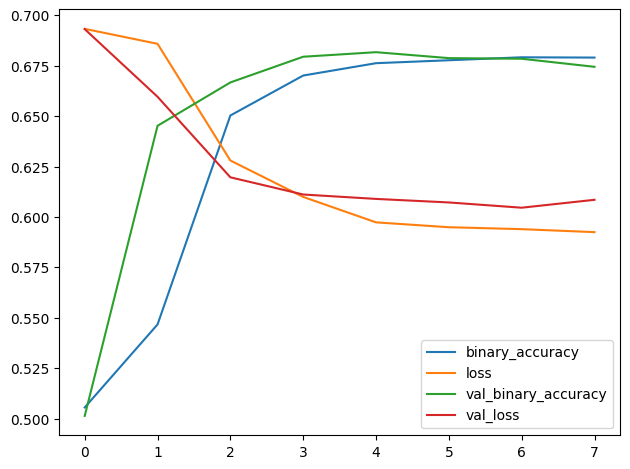

In [155]:
model_improved_500 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_improved_500.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_500.summary()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_500.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

In [156]:
model_improved_500.load_weights("load.weights.h5")

y_pred = model_improved_500.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_500 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Accuracy: 0.67435


model, který bude mít nejlepší accuracy zkusím number_of_tokens: 500, 1000, 2000, 5000, 10000, all unique words

### Results for 500 tokens

In [157]:
print('Accuracy for simple model: '+str(accuracy_simple_500))
print('Accuracy for improved model: '+str(accuracy_improved_500))

Accuracy for simple model: 0.6783
Accuracy for improved model: 0.67435


## Number of tokens: 1000

In [158]:
NUMBER_OF_TOKENS=1000 # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

review = df["clean_Review"].copy()

print("Example Sentence: ") 
print(review[29632])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[29632])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[29632])

X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

Example Sentence: 
movie fits perfectly terry gilliam oeuvre except fact dismal rank bore misses thematic mark becomes complete nightmare
Into a Sequence: 
[2, 487, 683, 315, 595, 203, 626]
After Padding: 
[  2 487 683 315 595 203 626   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - binary_accuracy: 0.5238 - loss: 0.6923 - val_binary_accuracy: 0.6226 - val_loss: 0.6784
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6524 - loss: 0.6538 - val_binary_accuracy: 0.6994 - val_loss: 0.5792
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7082 - loss: 0.5658 - val_binary_accuracy: 0.7086 - val_loss: 0.5620
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - binary_accuracy: 0.7164 - loss: 0.5508 - val_binary_accuracy: 0.7081 - val_loss: 0.5621
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7175 - loss: 0.5476 - val_binary_accuracy: 0.7089 - val_loss: 0.5585
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.7129


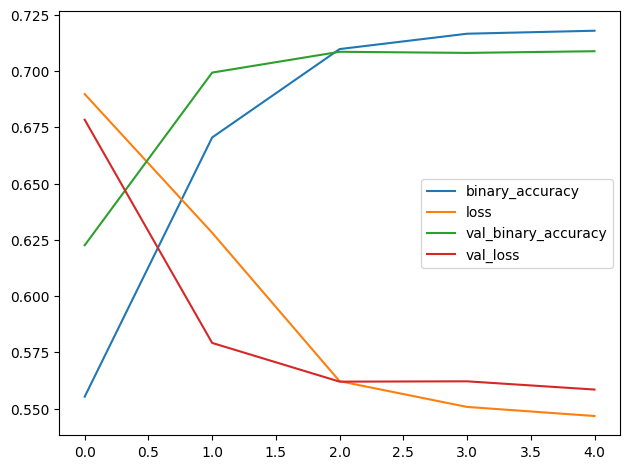

In [159]:
model_simple_1000 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])

model_simple_1000.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 5
batch_size=512

history = model_simple_1000.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_simple_1000.load_weights("load.weights.h5")

y_pred = model_simple_1000.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') #We can use accuracy because classes are balanced
accuracy_simple_1000 = accuracy_score(y_true=y_test, y_pred=y_pred)

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_36                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_23         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - binary_accuracy: 0.5085 - loss: 0.6929 - val_binary_accuracy: 0.5626 - val_loss: 0.6875
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.6235 - loss: 0.6486 - val_binary_accuracy: 0.7034 - val_loss: 0.5940
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.7016 - loss: 0.5766 - val_binary_accuracy: 0.6939 - val_loss: 0.5868
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.7117 - loss: 0.5640 - val_binary_accuracy: 0.7064 - val_loss: 0.5736
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7165 - loss: 0.5555 - val_binary_accuracy: 0.7029 - val_loss: 0.5826
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7177 - loss: 0.5540 - val_binary_accuracy: 0.7001 - val_loss: 0.5807
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7234 - loss: 0.5457 - val_binary_accuracy: 0.7067 - val_loss: 0.5741
Epoch 

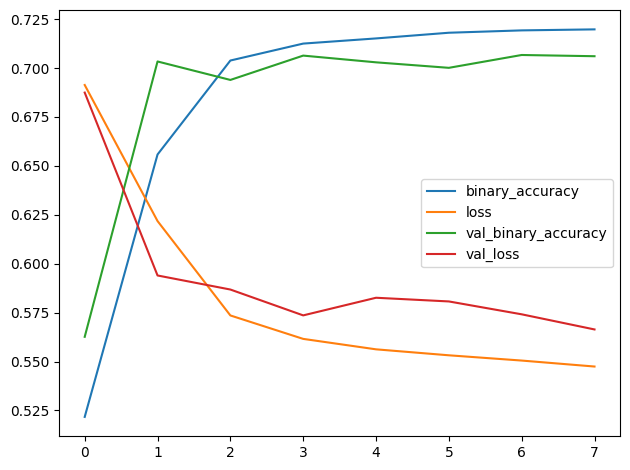

In [160]:
model_improved_1000 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_improved_1000.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_1000.summary()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_1000.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_improved_1000.load_weights("load.weights.h5")

y_pred = model_improved_1000.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_1000 = accuracy_score(y_true=y_test, y_pred=y_pred)

### Result for 1000 tokens

In [161]:
print('Accuracy for simple model: '+str(accuracy_simple_1000))
print('Accuracy for improved model: '+str(accuracy_improved_1000))

Accuracy for simple model: 0.7129
Accuracy for improved model: 0.7089


## Number of tokens: 2000

In [162]:
NUMBER_OF_TOKENS=2000 # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

review = df["clean_Review"].copy()

print("Example Sentence: ") 
print(review[29632])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[29632])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[29632])

X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

Example Sentence: 
movie fits perfectly terry gilliam oeuvre except fact dismal rank bore misses thematic mark becomes complete nightmare
Into a Sequence: 
[2, 1753, 487, 683, 315, 1372, 1650, 595, 203, 626, 1506]
After Padding: 
[   2 1753  487  683  315 1372 1650  595  203  626 1506    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0.5323 - loss: 0.6918 - val_binary_accuracy: 0.6329 - val_loss: 0.6688
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6788 - loss: 0.6317 - val_binary_accuracy: 0.7206 - val_loss: 0.5499
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7366 - loss: 0.5302 - val_binary_accuracy: 0.7295 - val_loss: 0.5326
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7516 - loss: 0.5079 - val_binary_accuracy: 0.7337 - val_loss: 0.5281
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7546 - loss: 0.5012 - val_binary_accuracy: 0.7325 - val_loss: 0.5253
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.7369


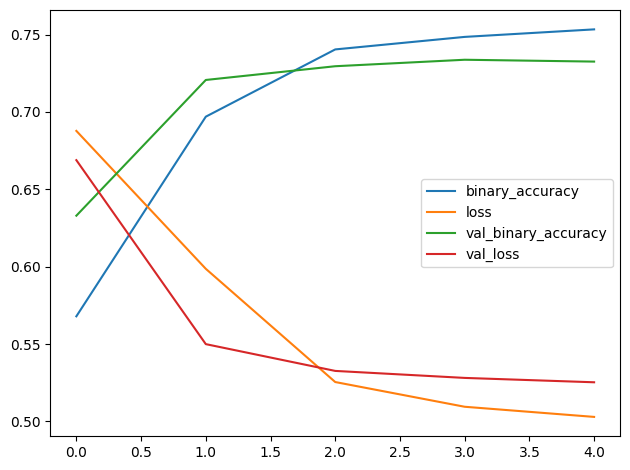

In [163]:
model_simple_2000 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])

model_simple_2000.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 5
batch_size=512

history = model_simple_2000.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_simple_2000.load_weights("load.weights.h5")

y_pred = model_simple_2000.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') #We can use accuracy because classes are balanced
accuracy_simple_2000 = accuracy_score(y_true=y_test, y_pred=y_pred)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_38                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_39                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_25         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - binary_accuracy: 0.5001 - loss: 0.6932 - val_binary_accuracy: 0.5438 - val_loss: 0.6900
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.5964 - loss: 0.6645 - val_binary_accuracy: 0.6769 - val_loss: 0.6099
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7292 - loss: 0.5505 - val_binary_accuracy: 0.7294 - val_loss: 0.5552
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.7465 - loss: 0.5213 - val_binary_accuracy: 0.7312 - val_loss: 0.5432
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7513 - loss: 0.5136 - val_binary_accuracy: 0.7284 - val_loss: 0.5512
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7543 - loss: 0.5079 - val_binary_accuracy: 0.7339 - val_loss: 0.5431
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7568 - loss: 0.5050 - val_binary_accuracy: 0.7322 - val_loss: 0.5325
Epoch 

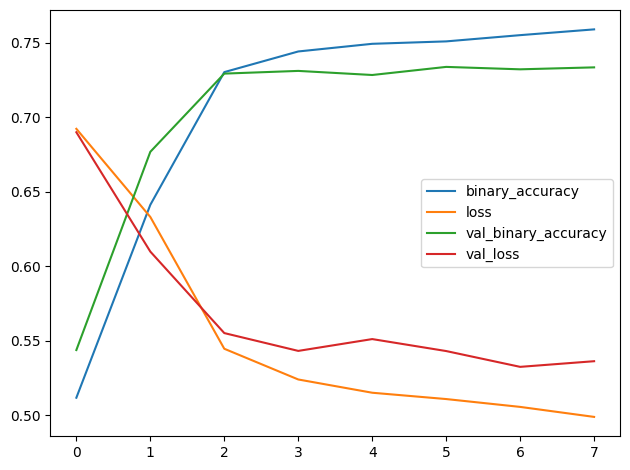

In [164]:
model_improved_2000 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_improved_2000.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_2000.summary()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_2000.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_improved_2000.load_weights("load.weights.h5")

y_pred = model_improved_2000.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_2000 = accuracy_score(y_true=y_test, y_pred=y_pred)

### Results for 2000 tokens

In [165]:
print('Accuracy for simple model: '+str(accuracy_simple_2000))
print('Accuracy for improved model: '+str(accuracy_improved_2000))

Accuracy for simple model: 0.7369
Accuracy for improved model: 0.73715


## Number of tokens: 5000

In [166]:
NUMBER_OF_TOKENS=5000 # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

review = df["clean_Review"].copy()

print("Example Sentence: ") 
print(review[29632])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[29632])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[29632])

X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

Example Sentence: 
movie fits perfectly terry gilliam oeuvre except fact dismal rank bore misses thematic mark becomes complete nightmare
Into a Sequence: 
[2, 1753, 487, 4117, 2816, 683, 315, 4701, 1372, 1650, 2237, 595, 203, 626, 1506]
After Padding: 
[   2 1753  487 4117 2816  683  315 4701 1372 1650 2237  595  203  626
 1506    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - binary_accuracy: 0.5359 - loss: 0.6905 - val_binary_accuracy: 0.6261 - val_loss: 0.6551
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.6728 - loss: 0.6221 - val_binary_accuracy: 0.7340 - val_loss: 0.5313
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7588 - loss: 0.4994 - val_binary_accuracy: 0.7556 - val_loss: 0.5017
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7836 - loss: 0.4601 - val_binary_accuracy: 0.7604 - val_loss: 0.4923
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7950 - loss: 0.4432 - val_binary_accuracy: 0.7585 - val_loss: 0.4990
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.759


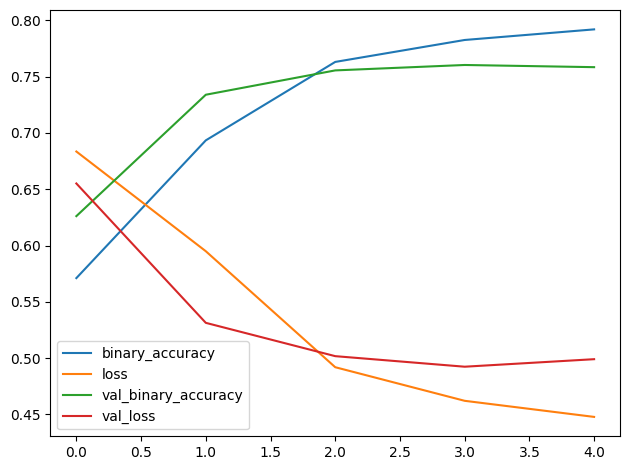

In [167]:
model_simple_5000 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])

model_simple_5000.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 5
batch_size=512

history = model_simple_5000.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_simple_5000.load_weights("load.weights.h5")

y_pred = model_simple_5000.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') #We can use accuracy because classes are balanced
accuracy_simple_5000 = accuracy_score(y_true=y_test, y_pred=y_pred)

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_41                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_42                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_27         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - binary_accuracy: 0.5024 - loss: 0.6931 - val_binary_accuracy: 0.5194 - val_loss: 0.6922
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.5519 - loss: 0.6842 - val_binary_accuracy: 0.7106 - val_loss: 0.5986
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7263 - loss: 0.5550 - val_binary_accuracy: 0.7528 - val_loss: 0.5348
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7739 - loss: 0.4917 - val_binary_accuracy: 0.7501 - val_loss: 0.5408
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.7853 - loss: 0.4717 - val_binary_accuracy: 0.7563 - val_loss: 0.5148
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.8025 - loss: 0.4477 - val_binary_accuracy: 0.7570 - val_loss: 0.5173
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.8059 - loss: 0.4367 - val_binary_accuracy: 0.7611 - val_loss: 0.5075
Epoch 

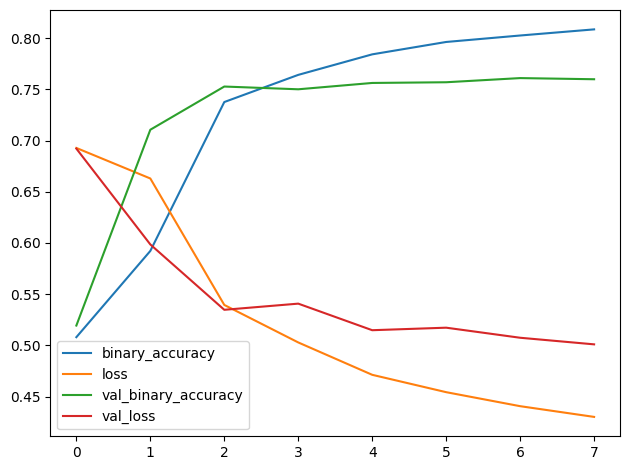

In [168]:
model_improved_5000 = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_improved_5000.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_5000.summary()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_5000.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_improved_5000.load_weights("load.weights.h5")

y_pred = model_improved_5000.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_5000 = accuracy_score(y_true=y_test, y_pred=y_pred)

### Results for 5000 tokens

In [169]:
print('Accuracy for simple model: '+str(accuracy_simple_5000))
print('Accuracy for improved model: '+str(accuracy_improved_5000))

Accuracy for simple model: 0.759
Accuracy for improved model: 0.7528


## Number of tokens: tokenize all words

In [170]:
NUMBER_OF_TOKENS=len(dist) # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

review = df["clean_Review"].copy()

print("Example Sentence: ") 
print(review[29632])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[29632])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[29632])

X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])


#for later purposes when using pipeline
test_reviews_clean = []

for i in range(len(X_test)):
    test_reviews_clean.append(token.sequences_to_texts([X_test[i]])[0])

Example Sentence: 
movie fits perfectly terry gilliam oeuvre except fact dismal rank bore misses thematic mark becomes complete nightmare
Into a Sequence: 
[2, 1753, 487, 4117, 2816, 5107, 683, 315, 4701, 5488, 1372, 1650, 2237, 595, 203, 626, 1506]
After Padding: 
[   2 1753  487 4117 2816 5107  683  315 4701 5488 1372 1650 2237  595
  203  626 1506    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - binary_accuracy: 0.5264 - loss: 0.6920 - val_binary_accuracy: 0.6211 - val_loss: 0.6796
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.6511 - loss: 0.6547 - val_binary_accuracy: 0.7335 - val_loss: 0.5543
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.7636 - loss: 0.5101 - val_binary_accuracy: 0.7632 - val_loss: 0.4983
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.8197 - loss: 0.4162 - val_binary_accuracy: 0.7746 - val_loss: 0.4822
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.8539 - loss: 0.3575 - val_binary_accuracy: 0.7790 - val_loss: 0.4855
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 0.7704


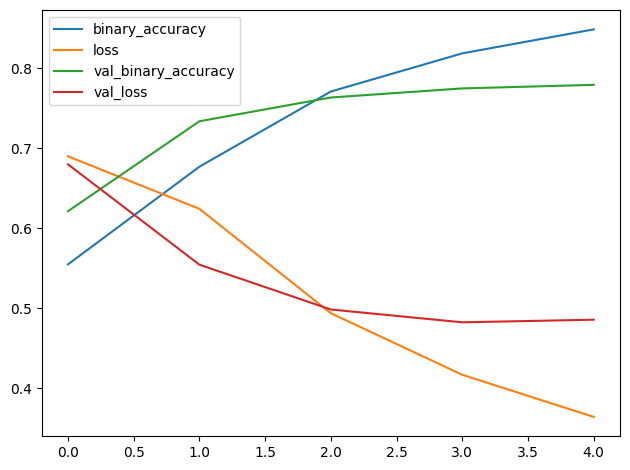

In [171]:
model_simple_all_words = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences = True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])

model_simple_all_words.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 5
batch_size=512

history = model_simple_all_words.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_simple_all_words.load_weights("load.weights.h5")

y_pred = model_simple_all_words.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') #We can use accuracy because classes are balanced
accuracy_simple_all_words = accuracy_score(y_true=y_test, y_pred=y_pred)

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_44                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_45                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_29         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - binary_accuracy: 0.5107 - loss: 0.6925 - val_binary_accuracy: 0.6288 - val_loss: 0.6713
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.6292 - loss: 0.6426 - val_binary_accuracy: 0.7487 - val_loss: 0.5409
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.7844 - loss: 0.4728 - val_binary_accuracy: 0.7671 - val_loss: 0.5017
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.8334 - loss: 0.3992 - val_binary_accuracy: 0.7636 - val_loss: 0.5061
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.8614 - loss: 0.3484 - val_binary_accuracy: 0.7724 - val_loss: 0.4881
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.8809 - loss: 0.3103 - val_binary_accuracy: 0.7769 - val_loss: 0.4750
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.8988 - loss: 0.2808 - val_binary_accuracy: 0.7771 - val_loss: 0.4764
Epoch 

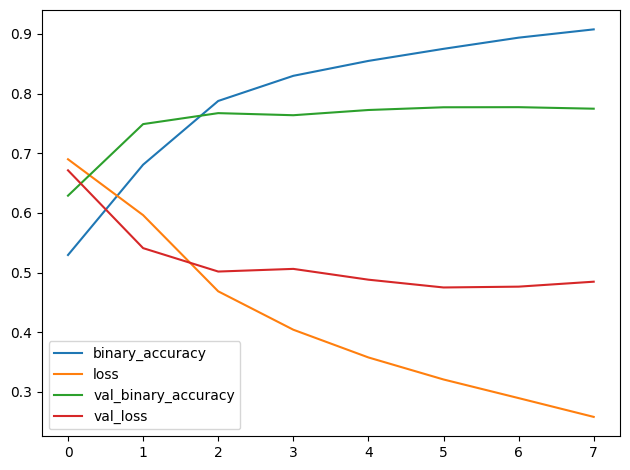

In [172]:
model_improved_all_words = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])


model_improved_all_words.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_all_words.summary()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_all_words.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_improved_all_words.load_weights("load.weights.h5")

y_pred = model_improved_all_words.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_all_words = accuracy_score(y_true=y_test, y_pred=y_pred)

### Results for all words as tokens

In [173]:
print('Accuracy for simple model: '+str(accuracy_simple_all_words))
print('Accuracy for improved model: '+str(accuracy_improved_all_words))

Accuracy for simple model: 0.7704
Accuracy for improved model: 0.7686


## Results

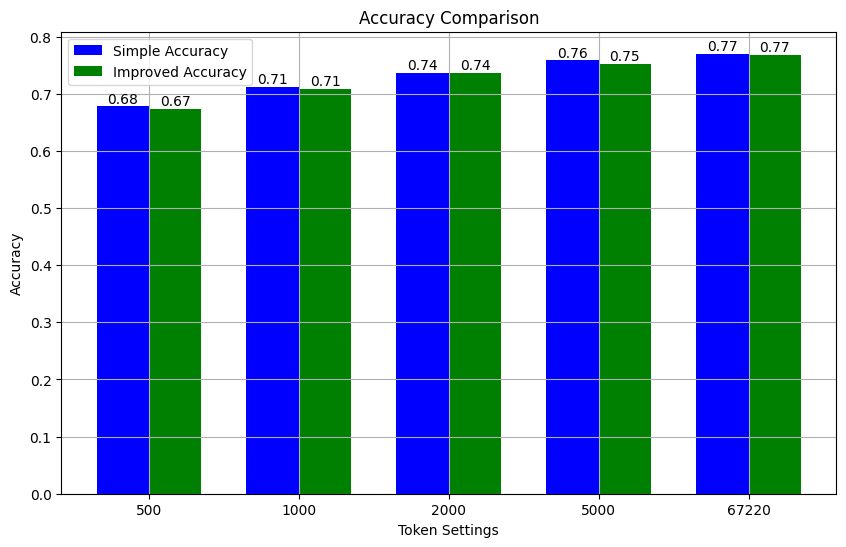

In [174]:
token_settings = [500, 1000, 2000, 5000, len(dist)]

accuracy_simple = [accuracy_simple_500, accuracy_simple_1000, accuracy_simple_2000, accuracy_simple_5000, accuracy_simple_all_words]
accuracy_improved = [accuracy_improved_500, accuracy_improved_1000, accuracy_improved_2000, accuracy_improved_5000, accuracy_improved_all_words]

bar_width = 0.35

ind = range(len(token_settings))

plt.figure(figsize=(10, 6))
bars1 = plt.bar(ind, accuracy_simple, width=bar_width, color='blue', label='Simple Accuracy')
bars2 = plt.bar([i + bar_width for i in ind], accuracy_improved, width=bar_width, color='green', label='Improved Accuracy')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')

plt.title('Accuracy Comparison')
plt.xlabel('Token Settings')
plt.ylabel('Accuracy')
plt.xticks([i + bar_width / 2 for i in ind], token_settings)  # Set x-axis labels
plt.legend()

plt.grid(True)
plt.show()

# Let's take a look at the difference between our clean reviews and non treated reviews

We will be using 5000 tokens and try it on our improved model

In [175]:
NUMBER_OF_TOKENS = 5000 # number of Unique tokens/words
MAX_LENGTH = 100       # Output dimension
EMBEDDING_DIM = 50     # Dimension of embedded representation

review = df["Review"].copy()

print("Example Sentence: ") 
print(review[0])

token = Tokenizer(num_words=NUMBER_OF_TOKENS) 
token.fit_on_texts(review)
texts = token.texts_to_sequences(review) 


print("Into a Sequence: ")
print(texts[0])

texts = pad_sequences(texts,maxlen=MAX_LENGTH, padding='post') 

print("After Padding: ")
print(texts[0])

X_train, X_test, y_train, y_test = train_test_split(texts, df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

Example Sentence: 
 Manakamana doesn't answer any questions, yet makes its point: Nepal, like the rest of our planet, is a picturesque but far from peaceable kingdom.
Into a Sequence: 
[73, 1922, 86, 705, 149, 88, 17, 247, 30, 1, 612, 4, 211, 1815, 6, 2, 10, 156, 29, 2209]
After Padding: 
[  73 1922   86  705  149   88   17  247   30    1  612    4  211 1815
    6    2   10  156   29 2209    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_46                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_30         │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - binary_accuracy: 0.5117 - loss: 0.6917 - val_binary_accuracy: 0.6096 - val_loss: 0.6630
Epoch 2/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - binary_accuracy: 0.6401 - loss: 0.6339 - val_binary_accuracy: 0.6388 - val_loss: 0.6304
Epoch 3/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.7467 - loss: 0.5262 - val_binary_accuracy: 0.7676 - val_loss: 0.5168
Epoch 4/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.7830 - loss: 0.4749 - val_binary_accuracy: 0.7746 - val_loss: 0.4942
Epoch 5/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.8045 - loss: 0.4367 - val_binary_accuracy: 0.7825 - val_loss: 0.4798
Epoch 6/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.8176 - loss: 0.4130 - val_binary_accuracy: 0.7822 - val_loss: 0.4747
Epoch 7/8
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - binary_accuracy: 0.8264 - loss: 0.3948 - val_binary_accuracy: 0.7822 - val_loss: 0.4657
Epoch 

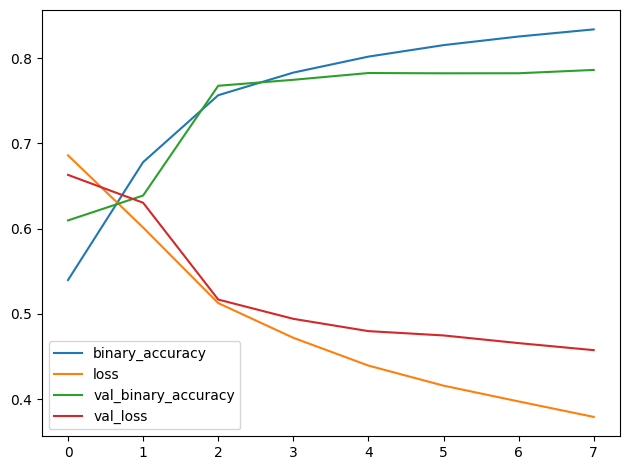

In [176]:
model_improved_5000_dirty = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUMBER_OF_TOKENS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid") #we have 2 labels ('negative','positive')
])

model_improved_5000_dirty.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

model_improved_5000_dirty.summary()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='load.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

epochs = 8
batch_size = 512

history = model_improved_5000_dirty.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[model_checkpoint_callback])

show_history(history)

model_improved_5000_dirty.load_weights("load.weights.h5")

In [177]:
y_pred = model_improved_5000_dirty.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}') 
accuracy_improved_5000_dirty = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Accuracy: 0.78565


interesting, we received similar results for "dirty" reviews and "clean" reviews.

# Let's see how well will hugging face models perform

We will be also testing comparison between "dirty" and "clean" reviews

In [178]:
X_train, X_test_reviews_dirty, y_train, y_test_reviews_dirty = train_test_split(df['Review'], df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

In [179]:
X_train, X_test_reviews_clean, y_train, y_test_reviews_clean = train_test_split(df['clean_Review'], df["Freshness"], test_size = 0.2, random_state = 42, stratify=df['Freshness'])

## distilbert/distilbert-base-uncased-finetuned-sst-2-english

In [180]:
X_test_reviews_clean = X_test_reviews_clean.tolist() 

In [181]:
X_test_reviews_clean[:3]

['film attempt get serious actually pays increasing emotional dividends moves along',
 'begins sexually charged energetic rock love story featuring two actresses pouring souls two iconic characters grinds halt beyond act one',
 "problem soul taken't concept execution overly complex nearly impossible explain images slasher turns visual table read final act"]

In [182]:
X_test_reviews_dirty = X_test_reviews_dirty.tolist() 

In [183]:
X_test_reviews_dirty[:3]

[" [The] film's attempt to get serious actually pays increasing emotional dividends as it moves along.",
 ' What begins as a sexually charged, energetic rock love story featuring two actresses pouring their souls into two iconic characters grinds to a halt beyond act one.',
 " The problem with My Soul to Take isn't in its concept, it's in the execution. It's overly complex and nearly impossible to explain with images, which is why the slasher turns into a visual table read in the final act."]

In [184]:
len(X_test_reviews_clean)

20000

our test samples consist of 20 000 reviews.

In [185]:
num_samples = len(test_reviews_clean)
batch_size = 64

pipe = pipeline("sentiment-analysis",model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english",tokenizer="distilbert/distilbert-base-uncased-finetuned-sst-2-english", truncation=True, max_length=512)

results_clean_1 = []
results_dirty_1 = []

for i in range(0, num_samples, batch_size):
    batch_inputs = X_test_reviews_clean[i:i+batch_size]
    results_clean_1.append(pipe(batch_inputs))
    batch_inputs = X_test_reviews_dirty[i:i+batch_size]
    results_dirty_1.append(pipe(batch_inputs))

In [186]:
results_clean_1[0][:10]

[{'label': 'NEGATIVE', 'score': 0.95248943567276},
 {'label': 'POSITIVE', 'score': 0.9994996786117554},
 {'label': 'NEGATIVE', 'score': 0.9974798560142517},
 {'label': 'POSITIVE', 'score': 0.9994045495986938},
 {'label': 'NEGATIVE', 'score': 0.9990398287773132},
 {'label': 'NEGATIVE', 'score': 0.9911184906959534},
 {'label': 'NEGATIVE', 'score': 0.999782383441925},
 {'label': 'POSITIVE', 'score': 0.748121440410614},
 {'label': 'POSITIVE', 'score': 0.9991462230682373},
 {'label': 'POSITIVE', 'score': 0.9950016140937805}]

In [187]:
all_results1 = [item for sublist in results_clean_1 for item in sublist]

y_pred_1 = []

for result in all_results1:
    if result['label'] == 'NEGATIVE':
        y_pred_1.append(0)
    else:
        y_pred_1.append(1)

y_pred_1 = np.array(y_pred_1)
print(f'Clean Accuracy: {accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_1)}') 
results_clean_1_score = accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_1)

Clean Accuracy: 0.75245


In [188]:
all_results1 = [item for sublist in results_dirty_1 for item in sublist]

y_pred_1 = []

for result in all_results1:
    if result['label'] == 'NEGATIVE':
        y_pred_1.append(0)
    else:
        y_pred_1.append(1)

y_pred_1 = np.array(y_pred_1)
print(f'Dirty Accuracy: {accuracy_score(y_true=y_test_reviews_dirty, y_pred=y_pred_1)}') 
results_dirty_1_score = accuracy_score(y_true=y_test_reviews_dirty, y_pred=y_pred_1)

Dirty Accuracy: 0.8263


## nlptown/bert-base-multilingual-uncased-sentiment

In [189]:
pipe = pipeline("sentiment-analysis",model = "nlptown/bert-base-multilingual-uncased-sentiment",tokenizer="nlptown/bert-base-multilingual-uncased-sentiment", truncation=True, max_length=512)

results_clean_2 = []
results_dirty_2 = []

for i in range(0, num_samples, batch_size):
    batch_inputs = X_test_reviews_clean[i:i+batch_size]
    results_clean_2.append(pipe(batch_inputs))
    batch_inputs = X_test_reviews_dirty[i:i+batch_size]
    results_dirty_2.append(pipe(batch_inputs))

In [190]:
results_clean_2[0][:10]

[{'label': '2 stars', 'score': 0.42357680201530457},
 {'label': '4 stars', 'score': 0.26557791233062744},
 {'label': '1 star', 'score': 0.7296954393386841},
 {'label': '4 stars', 'score': 0.43340420722961426},
 {'label': '1 star', 'score': 0.5860653519630432},
 {'label': '1 star', 'score': 0.2869022488594055},
 {'label': '1 star', 'score': 0.6820116639137268},
 {'label': '4 stars', 'score': 0.2846149206161499},
 {'label': '1 star', 'score': 0.48877081274986267},
 {'label': '5 stars', 'score': 0.28194743394851685}]

In [191]:
all_results2 = [item for sublist in results_clean_2 for item in sublist]

y_pred_2 = []

for result in all_results2:
    if result['label'] == '2 stars' or result['label'] == '1 star':
        y_pred_2.append(0)
    else:
        y_pred_2.append(1)

y_pred_2 = np.array(y_pred_2)
print(f'Accuracy: {accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_2)}') 
results_clean_2_score = accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_2)

Accuracy: 0.6832


In [192]:
all_results2 = [item for sublist in results_dirty_2 for item in sublist]

y_pred_2 = []

for result in all_results2:
    if result['label'] == '2 stars' or result['label'] == '1 star':
        y_pred_2.append(0)
    else:
        y_pred_2.append(1)

y_pred_2 = np.array(y_pred_2)
print(f'Accuracy: {accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_2)}') 
results_dirty_2_score = accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_2)

Accuracy: 0.6974


## finiteautomata/bertweet-base-sentiment-analysis

In [193]:
pipe = pipeline("sentiment-analysis",model = "finiteautomata/bertweet-base-sentiment-analysis",tokenizer="finiteautomata/bertweet-base-sentiment-analysis", truncation=True, max_length=512)

results_clean_3 = []
results_dirty_3 = []

for i in range(0, num_samples, batch_size):
    batch_inputs = X_test_reviews_clean[i:i+batch_size]
    results_clean_3.append(pipe(batch_inputs))
    batch_inputs = X_test_reviews_dirty[i:i+batch_size]
    results_dirty_3.append(pipe(batch_inputs))

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

IndexError: index out of range in self

In [ ]:
results_clean_3[0][:10]

In [ ]:
all_results3 = [item for sublist in results_clean_3 for item in sublist]

y_pred_3 = []

for result in all_results3:
    if result['label'] == 'NEG':
        y_pred_3.append(0)
    else:
        y_pred_3.append(1)

y_pred_3 = np.array(y_pred_3)
print(f'Accuracy: {accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_3)}') 
results_clean_3_score = accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_3)

In [ ]:
all_results3 = [item for sublist in results_dirty_3 for item in sublist]

y_pred_3 = []

for result in all_results3:
    if result['label'] == 'NEG':
        y_pred_3.append(0)
    else:
        y_pred_3.append(1)

y_pred_3 = np.array(y_pred_3)
print(f'Accuracy: {accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_3)}') 
results_dirty_3_score = accuracy_score(y_true=y_test_reviews_clean, y_pred=y_pred_3)

## Results

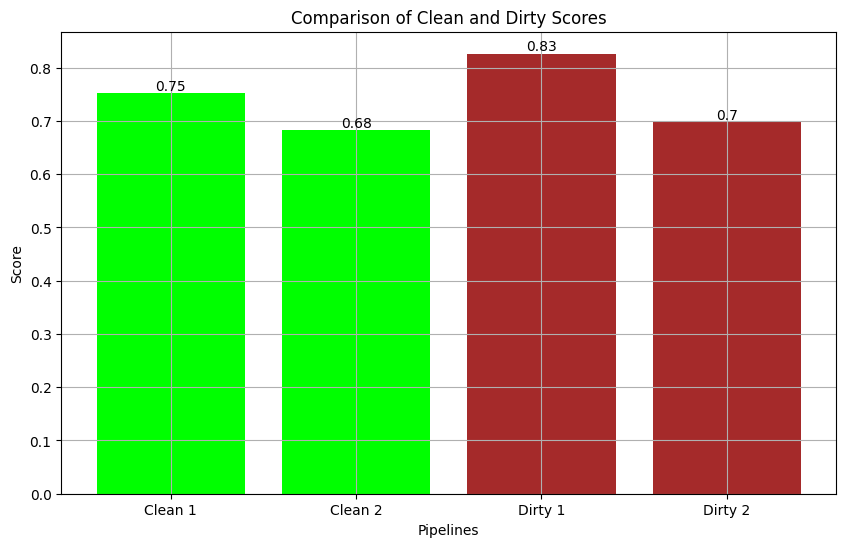

In [194]:
labels = ['Clean 1', 'Clean 2', 'Dirty 1', 'Dirty 2']
scores = [results_clean_1_score, results_clean_2_score, 
          results_dirty_1_score, results_dirty_2_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, scores, color=['lime', 'lime', 'brown', 'brown'])

plt.title('Comparison of Clean and Dirty Scores')
plt.xlabel('Pipelines')
plt.ylabel('Score')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.grid(True)
plt.show()

Best model performance was from **"distilbert/distilbert-base-uncased-finetuned-sst-2-english"** model.

What we have to take in consideration is that the other 2 models returned different results (POSITIVE,NEGATIVE,NEUTRAL and stars 1-5).


# Now let's try glove embedding

In [196]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-06-04 08:42:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-04 08:42:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-04 08:42:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [197]:
path_to_glove_file = 'glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [198]:
embeddings_index['film']

array([ 0.06912 ,  0.22159 , -0.66613 , -0.14061 ,  0.063365,  0.41747 ,
       -0.21723 , -1.0401  ,  0.026069,  1.3382  , -0.083642,  0.66324 ,
       -0.45989 ,  0.95883 ,  1.3185  , -0.62523 ,  0.56153 ,  0.65288 ,
       -1.2364  ,  0.29692 ,  1.238   ,  0.80621 ,  0.40967 ,  0.39945 ,
        0.57983 , -1.3658  , -1.6764  ,  0.069718, -0.59634 , -0.63117 ,
        2.5894  , -0.56915 ,  0.46879 , -0.9249  , -0.44629 ,  0.42283 ,
        0.17637 , -0.014459, -0.75358 , -0.9785  ,  0.023075,  1.2227  ,
       -0.17517 , -1.5743  , -0.9535  , -0.10959 ,  0.24517 , -0.93551 ,
       -0.20943 ,  0.67333 ], dtype=float32)

Let's take a look at 10 words that are most connected to word 'film' in glove embedding

In [199]:
target_word = 'film'
target_vector = embeddings_index[target_word]

similar_words = {}

for word, vector in embeddings_index.items():
    if word != target_word:
        similarity = cosine_similarity(target_vector, vector)
        similar_words[word] = similarity

sorted_similar_words = sorted(similar_words.items(), key=lambda item: item[1], reverse=True)

top_n = 10
for word, similarity in sorted_similar_words[:top_n]:
    print(f"Word: {word}, Similarity: {similarity}")

Word: movie, Similarity: 0.9310098886489868
Word: films, Similarity: 0.9236774444580078
Word: documentary, Similarity: 0.8718348145484924
Word: drama, Similarity: 0.8659579157829285
Word: comedy, Similarity: 0.8656219244003296
Word: directed, Similarity: 0.8434325456619263
Word: movies, Similarity: 0.8426743745803833
Word: acclaimed, Similarity: 0.8367619514465332
Word: adaptation, Similarity: 0.8153936862945557
Word: comic, Similarity: 0.8060662746429443


## Glove50d with clean reviews

In [200]:
embedding_dim = 50   # Embedding dimension -> GloVe 50
vocab_size = 10000
sequence_length = 50

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.clean_Review.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [201]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_Review, df.Freshness, test_size=0.2, random_state=13, stratify=df.Freshness)

In [202]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [203]:
print(X_train.shape, X_valid.shape, X_test.shape)

(72000,) (8000,) (20000,)


We need to map the `int` indices to the embedding vectors and save the mapping to the matrix

each row of the matrix is one token

In [204]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Words not found in embedding index will be all-zeros.
# This includes the representation for "padding" and "OOV"

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9716 words (284 misses)


In [205]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = LSTM(32, activation='relu', return_sequences=True)(emb)
x = GRU(32, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

glove50d_model1 = keras.Model(input_layer, output_layer)
glove50d_model1.summary()

glove50d_model1.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_31 (Embedding)        │ (None, 50, 50)         │       500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 50, 32)         │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,285 (1.99 MB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 500,100 (1.91 MB)

In [206]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.5013 - loss: 0.6932 - val_accuracy: 0.4996 - val_loss: 0.6931
Epoch 2/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.4996 - val_loss: 0.6932
Epoch 3/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.4996 - val_loss: 0.6932
Epoch 4/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4997 - val_loss: 0.6932
Epoch 5/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 36s 126ms/step - accuracy: 0.5021 - loss: 0.6931 - val_accuracy: 0.5004 - val_loss: 0.6931
Epoch 6/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 35s 126ms/step - accuracy: 0.4968 - loss: 0.6932 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 7/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.5004 - val_loss: 0.6931
Epoch 8/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - accuracy: 0.4985 - loss: 0.6932 - 

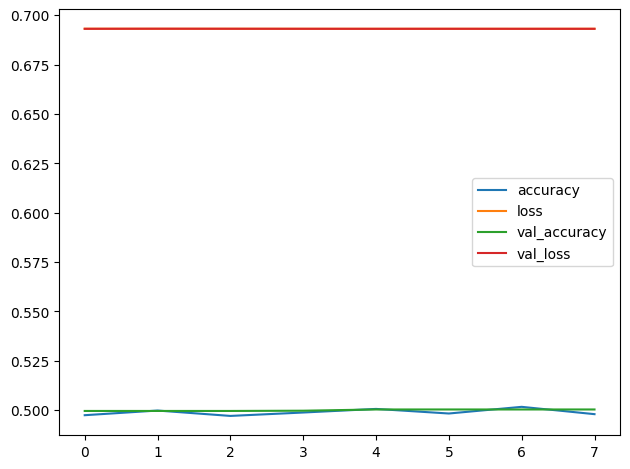

In [207]:
batch_size = 256
epochs = 8

history = glove50d_model1.fit(X_train.values, tf.cast(y_train.values, tf.float32), validation_data=(X_valid.values, tf.cast(y_valid.values, tf.float32)), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [208]:
glove50d_model1.load_weights("glove.weights.h5")

y_pred = glove50d_model1.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
accuracy_glove50d_model1 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step
Accuracy: 0.50035


## Glove50d with dirty Reviews

In [209]:
embedding_dim = 50   # Embedding dimension -> GloVe 50
vocab_size = 10000
sequence_length = 50

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Review.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

X_train, X_test, y_train, y_test = train_test_split(df.Review, df.Freshness, test_size=0.2, random_state=13, stratify=df.Freshness)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [210]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        

print("Converted %d words (%d misses)" % (hits, misses))

Converted 9709 words (291 misses)


In [211]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = LSTM(32, activation='relu', return_sequences=True)(emb)
x = GRU(32, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

glove50d_model2 = keras.Model(input_layer, output_layer)
glove50d_model2.summary()

glove50d_model2.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_32 (Embedding)        │ (None, 50, 50)         │       500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 50, 32)         │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,285 (1.99 MB)

 Trainable params: 21,185 (82.75 KB)

 Non-trainable params: 500,100 (1.91 MB)

Epoch 1/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.5041 - loss: 0.6931 - val_accuracy: 0.4996 - val_loss: 0.6927
Epoch 2/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.5430 - loss: 0.6876 - val_accuracy: 0.6539 - val_loss: 0.6354
Epoch 3/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.6355 - loss: 0.6493 - val_accuracy: 0.6450 - val_loss: 0.6215
Epoch 4/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.6563 - loss: 0.6239 - val_accuracy: 0.6871 - val_loss: 0.5834
Epoch 5/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.6826 - loss: 0.6000 - val_accuracy: 0.7103 - val_loss: 0.5608
Epoch 6/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.6912 - loss: 0.5866 - val_accuracy: 0.7091 - val_loss: 0.5682
Epoch 7/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.7002 - loss: 0.5748 - val_accuracy: 0.7222 - val_loss: 0.5457
Epoch 8/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.7047 - loss: 0.5698 - 

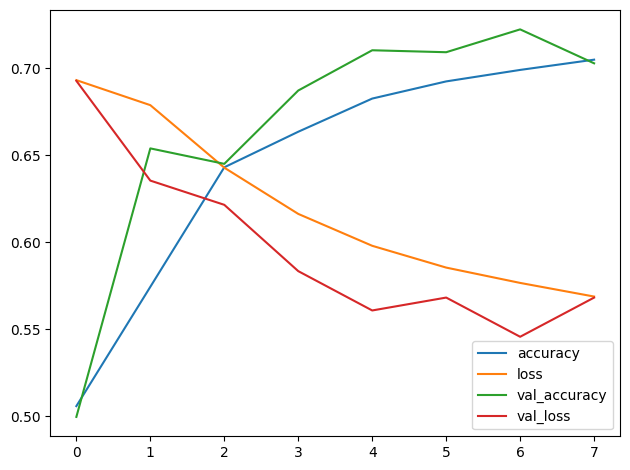

In [212]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 512
epochs = 8

history = glove50d_model2.fit(X_train.values, tf.cast(y_train.values, tf.float32), validation_data=(X_valid.values, tf.cast(y_valid.values, tf.float32)), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [213]:
glove50d_model2.load_weights("glove.weights.h5")

y_pred = glove50d_model2.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
accuracy_glove50d_model2 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step
Accuracy: 0.7079


## Glove100d with clean reviews 

In [214]:
path_to_glove_file = 'glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [215]:
embedding_dim = 100
vocab_size = 10000
sequence_length = 50

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Review.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

X_train, X_test, y_train, y_test = train_test_split(df.Review, df.Freshness, test_size=0.2, random_state=13, stratify=df.Freshness)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [216]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9709 words (291 misses)


In [217]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = LSTM(32, activation='relu', return_sequences=True)(emb)
x = GRU(32, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

glove100d_model1 = keras.Model(input_layer, output_layer)
glove100d_model1.summary()
glove100d_model1.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_33 (Embedding)        │ (None, 50, 100)        │     1,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 50, 32)         │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,027,785 (3.92 MB)

 Trainable params: 27,585 (107.75 KB)

 Non-trainable params: 1,000,200 (3.82 MB)

Epoch 1/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5025 - val_loss: 0.6932
Epoch 2/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.5075 - val_loss: 0.6930
Epoch 3/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.5024 - loss: 0.6930 - val_accuracy: 0.5479 - val_loss: 0.7028
Epoch 4/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.5958 - loss: 0.6747 - val_accuracy: 0.5834 - val_loss: 0.6835
Epoch 5/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.6606 - loss: 0.6273 - val_accuracy: 0.7150 - val_loss: 0.5801
Epoch 6/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.6938 - loss: 0.5941 - val_accuracy: 0.7131 - val_loss: 0.5481
Epoch 7/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.7092 - loss: 0.5705 - val_accuracy: 0.7350 - val_loss: 0.5392
Epoch 8/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.7193 - loss: 0.5542 - 

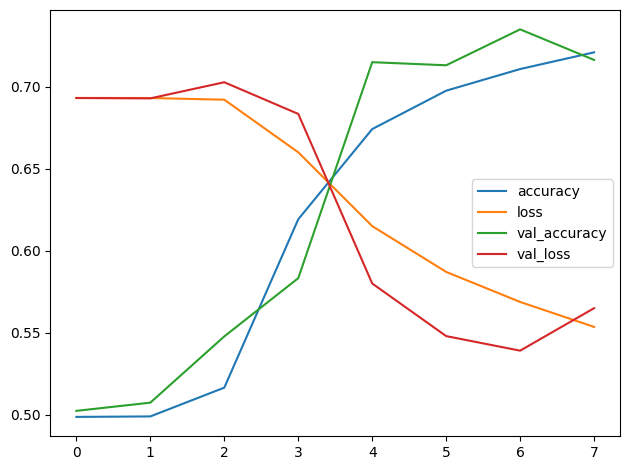

In [218]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 512
epochs = 8

history = glove100d_model1.fit(X_train.values, tf.cast(y_train.values, tf.float32), validation_data=(X_valid.values, tf.cast(y_valid.values, tf.float32)), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [219]:
glove100d_model1.load_weights("glove.weights.h5")

y_pred = glove100d_model1.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
accuracy_glove100d_model1 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step
Accuracy: 0.7243


## Glove200d with dirty reviews 

In [220]:
path_to_glove_file = 'glove.6B.200d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [221]:
embedding_dim = 200
vocab_size = 10000
sequence_length = 50

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Review.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

X_train, X_test, y_train, y_test = train_test_split(df.Review, df.Freshness, test_size=0.2, random_state=13, stratify=df.Freshness)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [222]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9709 words (291 misses)


In [223]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = LSTM(32, activation='relu', return_sequences=True)(emb)
x = GRU(32, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

glove200d_model1 = keras.Model(input_layer, output_layer)
glove200d_model1.summary()
glove200d_model1.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_34 (Embedding)        │ (None, 50, 200)        │     2,000,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 50, 32)         │        29,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,040,785 (7.78 MB)

 Trainable params: 40,385 (157.75 KB)

 Non-trainable params: 2,000,400 (7.63 MB)

Epoch 1/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.4975 - loss: 0.6932 - val_accuracy: 0.4996 - val_loss: 0.6932
Epoch 2/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.5015 - val_loss: 0.6931
Epoch 3/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.4990 - loss: 0.6932 - val_accuracy: 0.4990 - val_loss: 0.6932
Epoch 4/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5030 - loss: 0.6932 - val_accuracy: 0.4996 - val_loss: 0.6931
Epoch 5/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.4999 - loss: 0.6932 - val_accuracy: 0.5126 - val_loss: 0.6930
Epoch 6/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5098 - loss: 0.6943 - val_accuracy: 0.5476 - val_loss: 0.6883
Epoch 7/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.5750 - loss: 0.6808 - val_accuracy: 0.7030 - val_loss: 0.5875
Epoch 8/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.6852 - loss: 0.6075 - 

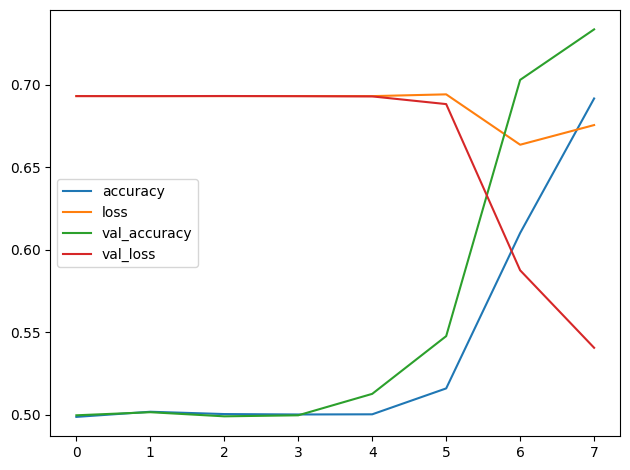

In [224]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 512
epochs = 8

history = glove200d_model1.fit(X_train.values, tf.cast(y_train.values, tf.float32), validation_data=(X_valid.values, tf.cast(y_valid.values, tf.float32)), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [225]:
glove200d_model1.load_weights("glove.weights.h5")

y_pred = glove100d_model1.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
accuracy_glove200d_model1 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step
Accuracy: 0.7243


## Glove300d with dirty reviews 

In [226]:
path_to_glove_file = 'glove.6B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [227]:
embedding_dim = 300
vocab_size = 10000
sequence_length = 50

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Review.values)

voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

X_train, X_test, y_train, y_test = train_test_split(df.Review, df.Freshness, test_size=0.2, random_state=13, stratify=df.Freshness)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [228]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9709 words (291 misses)


In [229]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = LSTM(32, activation='relu', return_sequences=True)(emb)
x = GRU(32, activation='relu', return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

glove300d_model1 = keras.Model(input_layer, output_layer)
glove300d_model1.summary()
glove300d_model1.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_4            │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_35 (Embedding)        │ (None, 50, 300)        │     3,000,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 50, 32)         │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,053,785 (11.65 MB)

 Trainable params: 53,185 (207.75 KB)

 Non-trainable params: 3,000,600 (11.45 MB)

Epoch 1/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.4986 - loss: 0.6932 - val_accuracy: 0.5066 - val_loss: 0.6931
Epoch 2/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5194 - val_loss: 0.6929
Epoch 3/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.5170 - loss: 0.6923 - val_accuracy: 0.6771 - val_loss: 0.6154
Epoch 4/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.6804 - loss: 0.6134 - val_accuracy: 0.7358 - val_loss: 0.5335
Epoch 5/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.6868 - loss: 1.5005 - val_accuracy: 0.7245 - val_loss: 0.5734
Epoch 6/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.7163 - loss: 0.5764 - val_accuracy: 0.6920 - val_loss: 0.5907
Epoch 7/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.7209 - loss: 0.5864 - val_accuracy: 0.7520 - val_loss: 0.5215
Epoch 8/8
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.7388 - loss: 0.5531 - 

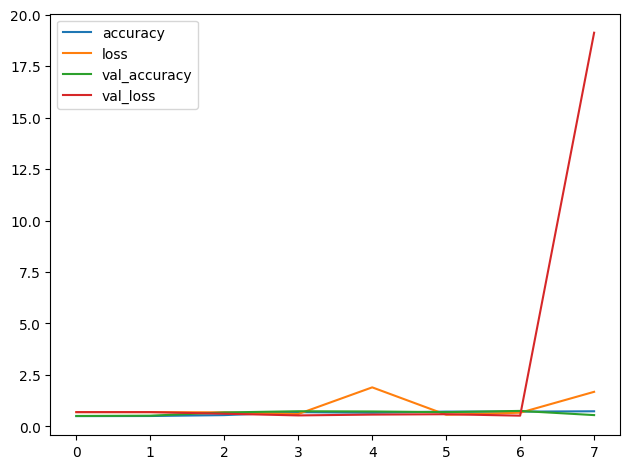

In [230]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='glove.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 512
epochs = 8

history = glove300d_model1.fit(X_train.values, tf.cast(y_train.values, tf.float32), validation_data=(X_valid.values, tf.cast(y_valid.values, tf.float32)), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [231]:
glove300d_model1.load_weights("glove.weights.h5")

y_pred = glove300d_model1.predict(X_test).ravel()
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
accuracy_glove300d_model1 = accuracy_score(y_true=y_test, y_pred=y_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step
Accuracy: 0.73925


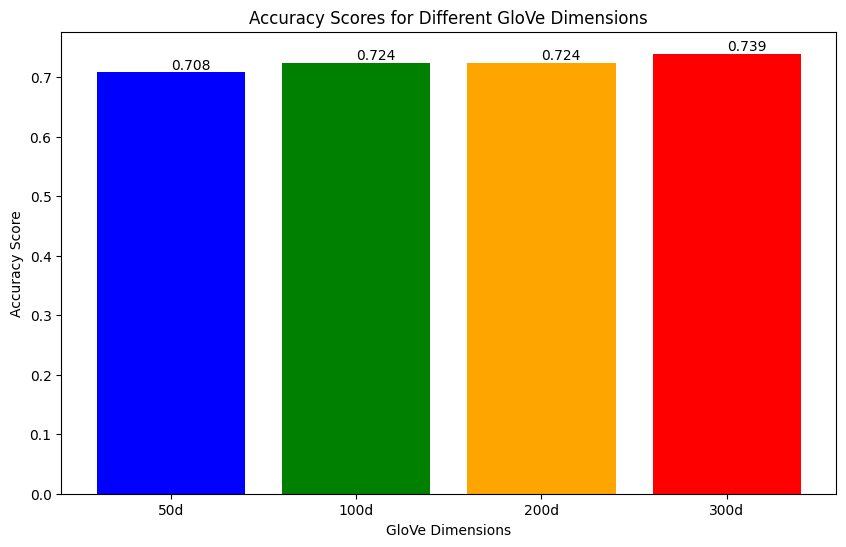

In [232]:
dimensions = ['50d', '100d', '200d', '300d']
accuracies = [accuracy_glove50d_model2, accuracy_glove100d_model1, accuracy_glove200d_model1, accuracy_glove300d_model1]

plt.figure(figsize=(10, 6))
bars = plt.bar(dimensions, accuracies, color=['blue', 'green', 'orange', 'red'])

for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(accuracy, 3), va='bottom')  # va: vertical alignment

plt.title('Accuracy Scores for Different GloVe Dimensions')
plt.xlabel('GloVe Dimensions')
plt.ylabel('Accuracy Score')

# Show the plot
plt.show()


# Results

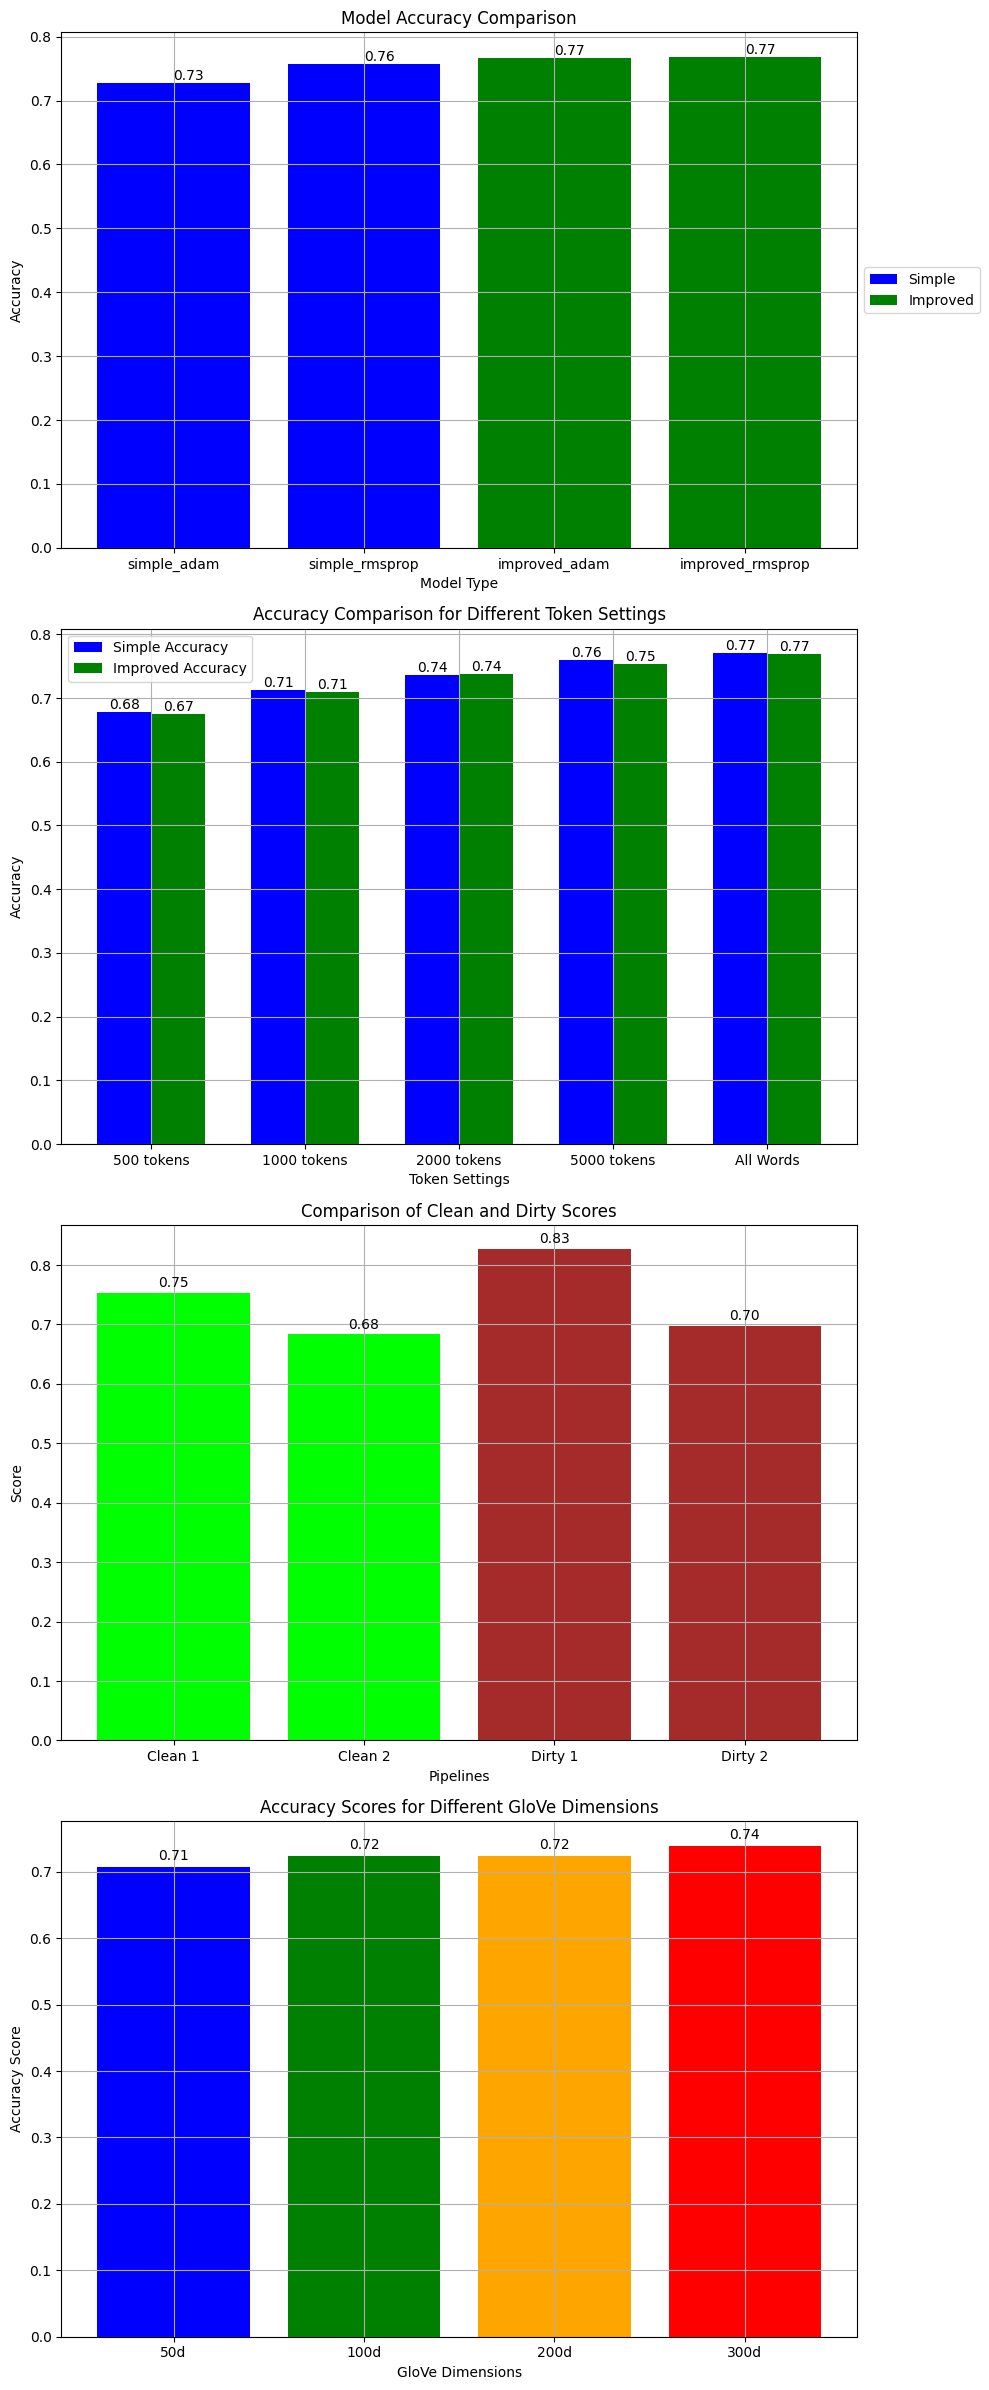

In [ ]:
labels = list(results.keys())
accuracies = list(results.values())

fig, axs = plt.subplots(4, 1, figsize=(10, 24))

colors = ['blue', 'blue', 'green', 'green']
bars = axs[0].bar(labels, accuracies, color=colors)
axs[0].set_title('Model Accuracy Comparison')
axs[0].set_xlabel('Model Type')
axs[0].set_ylabel('Accuracy')
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')
legend_elements = [Patch(facecolor='blue', label='Simple'),
                   Patch(facecolor='green', label='Improved')]
axs[0].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].grid(True)

token_settings = ['500 tokens', '1000 tokens', '2000 tokens', '5000 tokens', 'All Words']
accuracy_simple = [accuracy_simple_500, accuracy_simple_1000, accuracy_simple_2000, accuracy_simple_5000, accuracy_simple_all_words]
accuracy_improved = [accuracy_improved_500, accuracy_improved_1000, accuracy_improved_2000, accuracy_improved_5000, accuracy_improved_all_words]

bar_width = 0.35
ind = np.arange(len(token_settings))
bars1 = axs[1].bar(ind, accuracy_simple, width=bar_width, color='blue', label='Simple Accuracy')
bars2 = axs[1].bar(ind + bar_width, accuracy_improved, width=bar_width, color='green', label='Improved Accuracy')
for bar in bars1:
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')
for bar in bars2:
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2), ha='center', va='bottom')
axs[1].set_title('Accuracy Comparison for Different Token Settings')
axs[1].set_xlabel('Token Settings')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(ind + bar_width / 2)
axs[1].set_xticklabels(token_settings)
axs[1].legend()
axs[1].grid(True)

labels_clean_dirty = ['Clean 1', 'Clean 2', 'Dirty 1', 'Dirty 2']
scores_clean_dirty = [results_clean_1_score, results_clean_2_score, results_dirty_1_score, results_dirty_2_score]
bars = axs[2].bar(labels_clean_dirty, scores_clean_dirty, color=['lime', 'lime', 'brown', 'brown'])
axs[2].set_title('Comparison of Clean and Dirty Scores')
axs[2].set_xlabel('Pipelines')
axs[2].set_ylabel('Score')
for i, v in enumerate(scores_clean_dirty):
    axs[2].text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom')
axs[2].grid(True)

dimensions = ['50d', '100d', '200d', '300d']
accuracies_glove = [accuracy_glove50d_model2, accuracy_glove100d_model1, accuracy_glove200d_model1, accuracy_glove300d_model1]
bars = axs[3].bar(dimensions, accuracies_glove, color=['blue', 'green', 'orange', 'red'])
axs[3].set_title('Accuracy Scores for Different GloVe Dimensions')
axs[3].set_xlabel('GloVe Dimensions')
axs[3].set_ylabel('Accuracy Score')
for i, v in enumerate(accuracies_glove):
    axs[3].text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom')
axs[3].grid(True)

plt.tight_layout()
plt.show()

## First part (simple vs improved model)

In the first part, we tried to 2 models, **simple and improved** and also 2 different optimizers **RMSprop and adam**.

**On simple model different optimizers had pretty significant effect**. On the improved model not so much.

Interestingly **we received similar results for simple and improved models** which used RMSprop optimizer. Accuracy: **0.77%**



## Second part (different number of tokens)

Then we tried different number of tokens on *dirty* and *clean* Reviews.

There we saw improvement when increasing number of tokens. **500 tokens had accuracy 0.68** and **5000 tokens accuracy 0.76**.

There was just a **little improvement** between 5000 tokens and tokenizing all unique words in Reviews

Also there **wasn't difference if we used *clean* or *dirty* Reviews.**

## Third part (Hugging Face)

Best model performance was from **"distilbert/distilbert-base-uncased-finetuned-sst-2-english"** model.

**83% accuracy** reached on dirty Reviews is pretty good.

But only **75% accuracy** reached on our clean Reviews.


What we have to take in consideration is that the other model returned different results *stars 1-5*.



## Fourth part (Glove)

Now finally we tried Glove embedding.

**Glove300d** turned out to be **most accurace** from all 4 with accuracy **0.74%**.

But the difference between others was small because **Glove50d (the least accurate of them)** reached **0.71%** accuracy 

## Best accuracy?

Overall the best model to determine if the Review is negative or positive is from Hugging Face: **"distilbert/distilbert-base-uncased-finetuned-sst-2-english"**.

With **83% accuracy** on dirty Reviews.